In [130]:
import requests # for the COVID-19 india API

#Data handling
import numpy as np
import pandas as pd

#Data Visualisation
import matplotlib.pyplot as plt
from matplotlib import ticker
from datetime import datetime
import seaborn as sns
import plotly.express as px
import geopandas as gdp # For plotting choropleth map of India

#ARIMA model
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Machine Learning models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

#Deep learning models
from keras.layers import Input, Dense, Activation, LeakyReLU, Dropout
from keras import models
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Loading datasets

In [131]:
# Countrywise global data
df_global_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_global_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_global_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

# Countrywise latest data
df_countrywise = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-30-2020.csv")

# Testing data
df_test = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/testing/covid-testing-all-observations.csv')

In [132]:
print("Confirmed shape: ", df_global_confirmed.shape)
print("Deaths shape: ", df_global_deaths.shape)
print("Recovered shape: ", df_global_recovered.shape)

Confirmed shape:  (266, 196)
Deaths shape:  (266, 196)
Recovered shape:  (253, 196)


### Defining utility functions

In [133]:
def calculate_null(df):
    """
    Calculate null values column-wise and displays them.
    """
    nullCount = df.isnull().sum()
    nullColumns = df.loc[:,nullCount > 0].columns.tolist()
    for col in nullColumns:
        print(col, df[col].isnull().sum())


def combine_dataframe(df):
    """
    Input: Takes a dataframe with country-wise time-series values.
    Output: Returns the sum of values for all the countries at a particular date.
    """
    combined = {}
    for col in df.keys().tolist()[1:]:
        combined[col] = df[col].sum()
    df_combined = pd.DataFrame(combined, index=[0])
    
    return df_combined


## Covid-19 : Global Analysis

### Data Preprocessing 

In [134]:
df_global_confirmed.head(3)

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  7/22/20  7/23/20  7/24/20  \
0        0        0        0        0  ...    35727    35928    35981   
1        0        0        0        0  ...     4358     4466     4570   
2        0        0        0        0  ...    24872    25484    26159   

   7/25/20  7/26/20  7/27/20  7/28/20  7/29/20  7/30/20  7/31/20  
0    36036    36157    36263    36368    36471    36542    36675  
1     4637     4763     4880     4997     5105     5197     5276  
2    26764    27357    27973    28615    29229    29831    30394  

[3 rows x 196 columns]

In [135]:
df_global_deaths.head(3)

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  7/22/20  7/23/20  7/24/20  \
0        0        0        0        0  ...     1190     1211     1225   
1        0        0        0        0  ...      120      123      128   
2        0        0        0        0  ...     1111     1124     1136   

   7/25/20  7/26/20  7/27/20  7/28/20  7/29/20  7/30/20  7/31/20  
0     1248     1259     1269     1270     1271     1271     1272  
1      134      138      144      148      150      154      157  
2     1146     1155     1163     1174     1186     1200     1210  

[3 rows x 196 columns]

In [136]:
df_global_recovered.head(3)

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  7/22/20  7/23/20  7/24/20  \
0        0        0        0        0  ...    23924    24550    24602   
1        0        0        0        0  ...     2463     2523     2608   
2        0        0        0        0  ...    16983    17369    17369   

   7/25/20  7/26/20  7/27/20  7/28/20  7/29/20  7/30/20  7/31/20  
0    24793    25180    25198    25358    25389    25471    25509  
1     2637     2682     2745     2789     2830     2883     2952  
2    18076    18088    18837    19233    19592    20082    20537  

[3 rows x 196 columns]

In [137]:
# Renaming columns

df_global_confirmed.rename({'Province/State':'State', 'Country/Region':'Country'}, axis='columns', inplace=True)
df_global_deaths.rename({'Province/State':'State', 'Country/Region':'Country'}, axis='columns', inplace=True)
df_global_recovered.rename({'Province/State':'State', 'Country/Region':'Country'}, axis='columns', inplace=True)

In [138]:
# Columns with null values

print("Null Values")

print("Global confirmed Data: ")
calculate_null(df_global_confirmed)
    
print("Global deaths Data: ")
calculate_null(df_global_deaths)
    
print("Global recovered Data: ")
calculate_null(df_global_recovered)

Null Values
Global confirmed Data: 
State 185
Global deaths Data: 
State 185
Global recovered Data: 
State 186


In [139]:
# Removing States due to most null values and lat long due to unusability 

df_global_confirmed.drop(['State', 'Lat', 'Long'], axis=1, inplace=True)
df_global_deaths.drop(['State', 'Lat', 'Long'], axis=1, inplace=True)
df_global_recovered.drop(['State', 'Lat', 'Long'], axis=1, inplace=True)

In [140]:
df_global_confirmed = df_global_confirmed.iloc[:, :162]
df_global_deaths = df_global_deaths.iloc[:, :162]
df_global_recovered = df_global_recovered.iloc[:, :162]

In [141]:
# Summing values for all the countires

df_combined_confirmed = combine_dataframe(df_global_confirmed)
df_combined_deaths = combine_dataframe(df_global_deaths)
df_combined_recovered = combine_dataframe(df_global_recovered)

df_combined_confirmed

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
0      555      654      941     1434     2118     2927     5578     6166   

   1/30/20  1/31/20  ...  6/21/20  6/22/20  6/23/20  6/24/20  6/25/20  \
0     8234     9927  ...  8935203  9072474  9237859  9409094  9587076   

   6/26/20  6/27/20   6/28/20   6/29/20   6/30/20  
0  9778491  9956663  10118389  10276540  10450359  

[1 rows x 161 columns]

In [142]:
# Latest Global Statistics 

total_confirmed = df_combined_confirmed.iloc[0, -1]
total_deaths = df_combined_deaths.iloc[0, -1]
total_recovered = df_combined_recovered.iloc[0, -1]
active = total_confirmed - (total_deaths + total_recovered)
global_mortality_rate = np.round(100 * (total_deaths / total_confirmed), 2) #Death-to-case ratio

df_global_summary = pd.DataFrame({'Confirmed':total_confirmed, 'Deaths':[total_deaths], 'Recovered':[total_recovered], 'Active':[active], 'Mortality Rate': [global_mortality_rate]})
df_global_summary

Confirmed  Deaths  Recovered   Active  Mortality Rate
0   10450359  511224    5353115  4586020            4.89

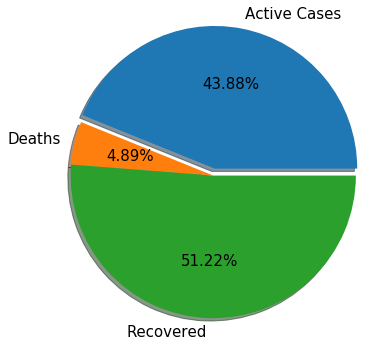

In [143]:
# plotting the distributions as a pie-chart

percDeaths = (total_deaths / total_confirmed) * 100
percRecovered = (total_recovered / total_confirmed) * 100
percActive = (active / total_confirmed) * 100

labels = 'Active Cases', 'Deaths', 'Recovered'
explode = [0.05, 0, 0]
sizes = [percActive, percDeaths, percRecovered]
textprops = {"fontsize":15}

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%', shadow = True, textprops = textprops)
ax.axis('equal')
# plt.savefig('./paper/output1.png', bbox_inches='tight')
# plt.title('Comparison of Active cases, Recovered cases and Deaths')
plt.show()

## Global Statistics over time

### Confirmed Cases

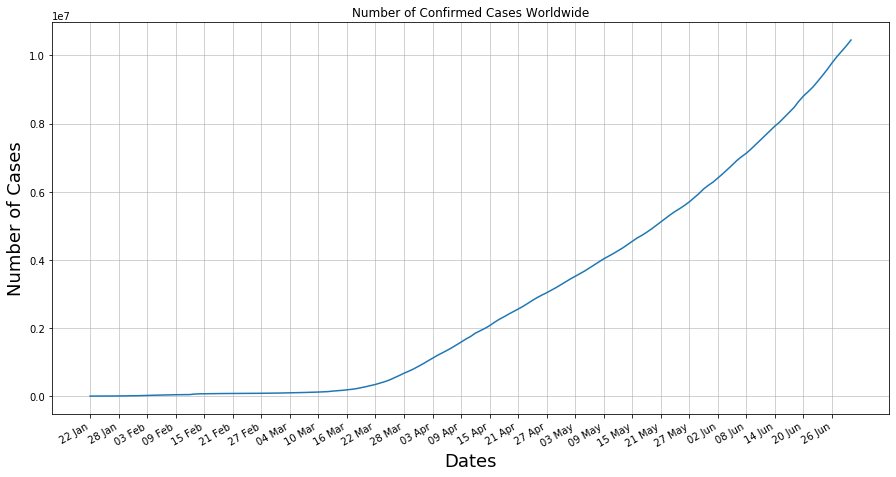

In [144]:
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in df_combined_confirmed.keys().tolist()]

fig = plt.figure(figsize=(15,8))
fig.add_subplot(111)
plt.plot(d, df_combined_confirmed.T)
fig.autofmt_xdate()
plt.tick_params(labelsize = 10)
plt.xticks(list(np.arange(0,len(d),int(len(d)/25))))
plt.title('Number of Confirmed Cases Worldwide')
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Number of Cases",fontsize=18)
plt.grid(alpha = 0.7)
plt.show()

### Deaths

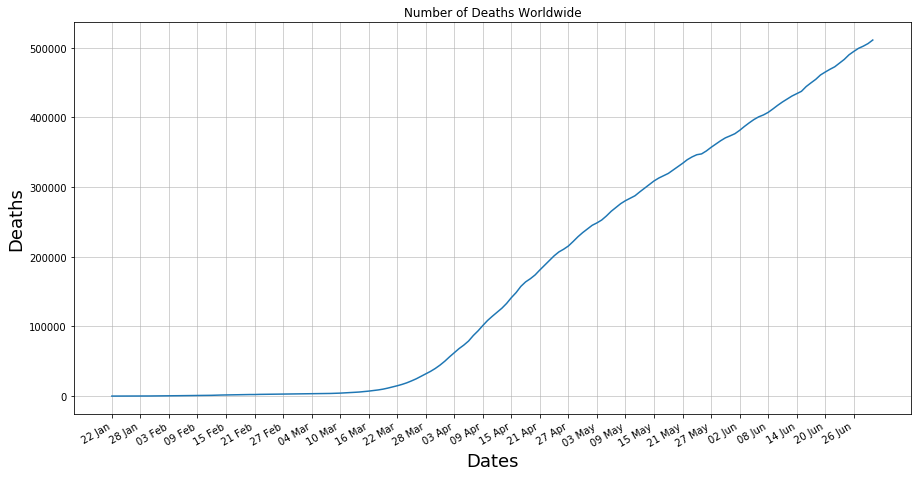

In [145]:
fig = plt.figure(figsize=(15,8))
fig.add_subplot(111)
plt.plot(d, df_combined_deaths.T)
fig.autofmt_xdate()
plt.tick_params(labelsize = 10)
plt.xticks(list(np.arange(0,len(d),int(len(d)/25))))
plt.title('Number of Deaths Worldwide')
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Deaths",fontsize=18)
plt.grid(alpha = 0.7)
plt.show()

### Recovered Cases

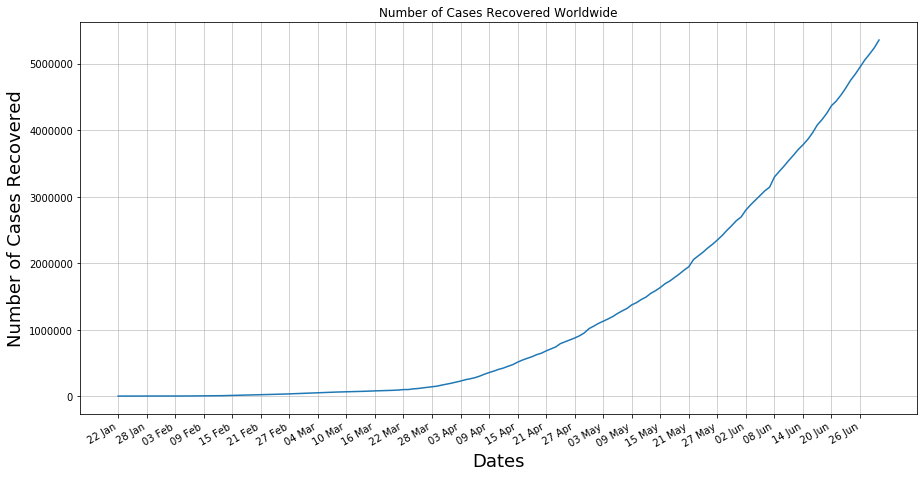

In [146]:
fig = plt.figure(figsize=(15,8))
fig.add_subplot(111)
plt.plot(d, df_combined_recovered.T)
fig.autofmt_xdate()
plt.tick_params(labelsize = 10)
plt.xticks(list(np.arange(0,len(d),int(len(d)/25))))
plt.title('Number of Cases Recovered Worldwide')
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Number of Cases Recovered",fontsize=18)
plt.grid(alpha = 0.7)
plt.show()

### Comparing the trends

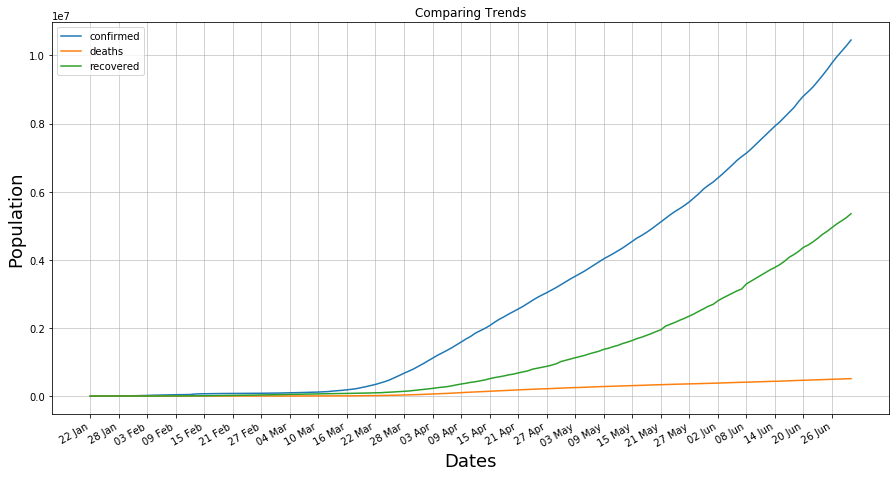

In [147]:
fig = plt.figure(figsize=(15,8))
fig.add_subplot(111)
plt.plot(d, df_combined_confirmed.T, label='confirmed')
plt.plot(d, df_combined_deaths.T, label='deaths')
plt.plot(d, df_combined_recovered.T, label='recovered')
fig.autofmt_xdate()
plt.tick_params(labelsize = 10)
plt.xticks(list(np.arange(0,len(d),int(len(d)/25))))
plt.title('Comparing Trends')
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Population",fontsize=18)
plt.grid(alpha = 0.7)
plt.legend(loc='best')
# plt.savefig('./paper/output3.png', bbox_inches='tight')
plt.show()

## Daywise Numbers

In [148]:
#Getting the daywise numbers

def daywise_data(df):
    '''
    Input: Takes a dataframe with cumulative time series data as input
    Output: Returns a dataframe with daywise numbers.
    '''
    daywise = pd.DataFrame(index=df.index, columns=df.keys())
    for day, date in enumerate(df.keys().tolist()):
        if day == 0:
            daywise[date] = df.iloc[:, day]
        else:
            daywise[date] = df.iloc[:, day]-df.iloc[:,day-1]
    return daywise

days = [i for i in range(len(df_combined_confirmed.keys()))]
days = np.array(days).reshape(-1, 1)
daywise_confirmed = daywise_data(df_combined_confirmed)
daywise_deaths = daywise_data(df_combined_deaths)
daywise_recovered = daywise_data(df_combined_recovered)

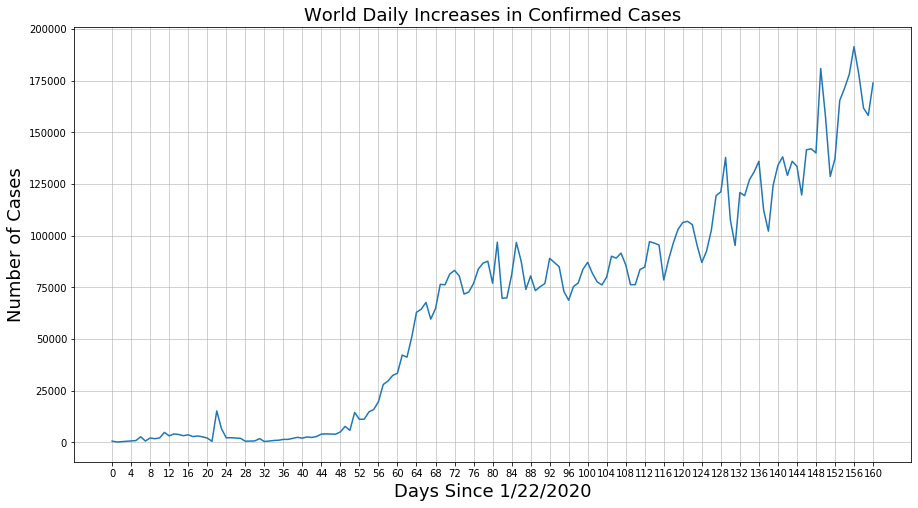

In [149]:

plt.figure(figsize=(15, 8))
plt.plot(days, daywise_confirmed.T)
plt.title('World Daily Increases in Confirmed Cases', fontsize=18)
plt.xticks(list(np.arange(0,len(days),int(len(days)/35))))
plt.xlabel('Days Since 1/22/2020', fontsize=18)
plt.ylabel('Number of Cases', fontsize=18)
plt.grid(alpha=0.7)
plt.show()

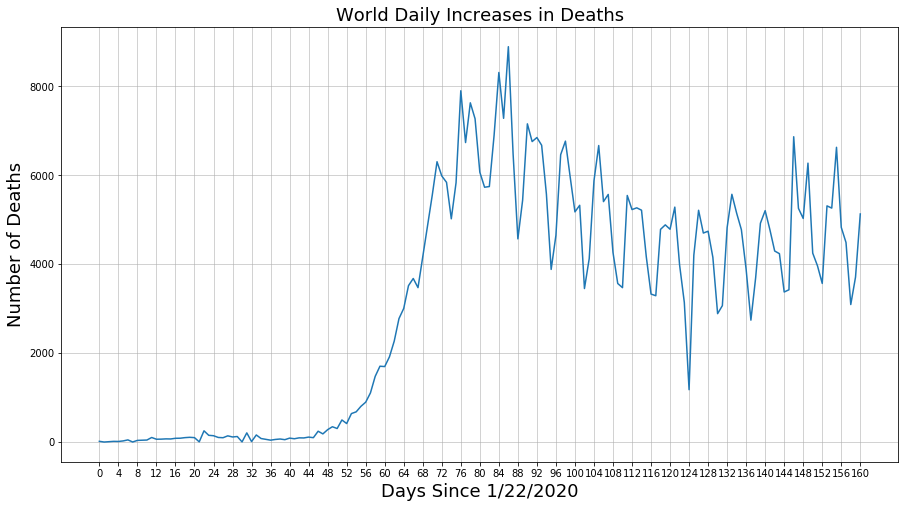

In [150]:
plt.figure(figsize=(15, 8))
plt.plot(days, daywise_deaths.T)
plt.title('World Daily Increases in Deaths', fontsize=18)
plt.xticks(list(np.arange(0,len(days),int(len(days)/35))))
plt.xlabel('Days Since 1/22/2020', fontsize=18)
plt.ylabel('Number of Deaths', fontsize=18)
plt.grid(alpha=0.7)
plt.show()

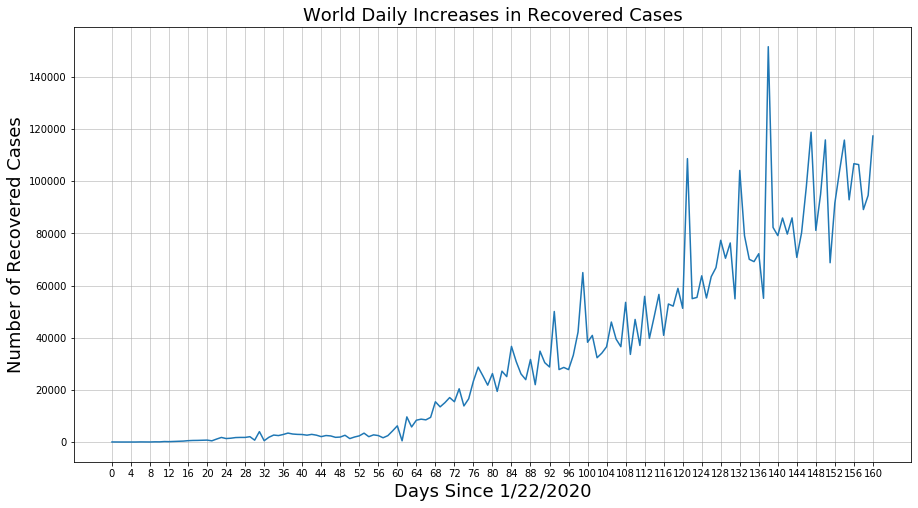

In [151]:
plt.figure(figsize=(15, 8))
plt.plot(days, daywise_recovered.T)
plt.title('World Daily Increases in Recovered Cases', fontsize=18)
plt.xticks(list(np.arange(0,len(days),int(len(days)/35))))
plt.xlabel('Days Since 1/22/2020', fontsize=18)
plt.ylabel('Number of Recovered Cases', fontsize=18)
plt.grid(alpha=0.7)
plt.show()

### Comparing the trends

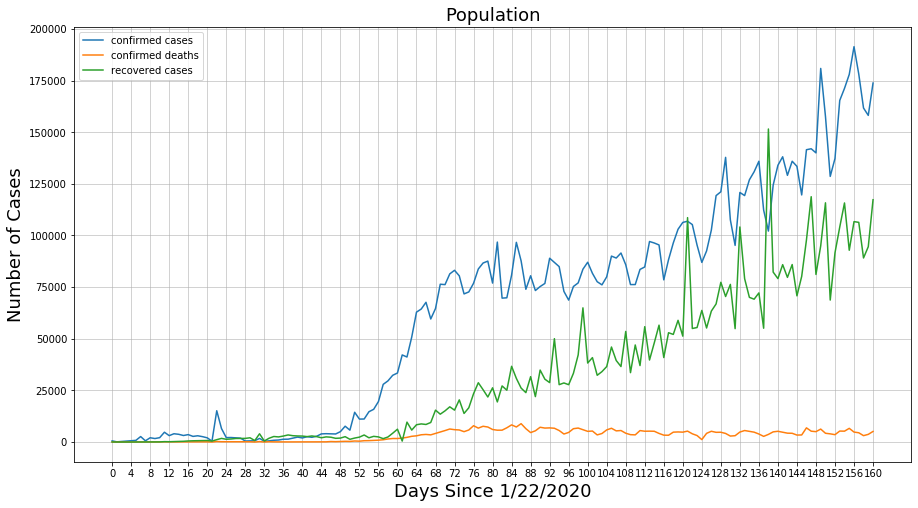

In [152]:
plt.figure(figsize=(15, 8))
plt.plot(days, daywise_confirmed.T, label='confirmed cases')
plt.plot(days, daywise_deaths.T, label='confirmed deaths')
plt.plot(days, daywise_recovered.T, label='recovered cases')
plt.title('Population', fontsize=18)
plt.xticks(list(np.arange(0,len(days),int(len(days)/35))))
plt.xlabel('Days Since 1/22/2020', fontsize=18)
plt.ylabel('Number of Cases', fontsize=18)
plt.grid(alpha=0.7)
plt.legend(loc='best')
# plt.savefig('./paper/output4.png', bbox_inches='tight')
plt.show()

## Country-wise Data analysis

### Loading and preprocessing data

In [153]:
df_countrywise.head()

FIPS     Admin2  Province_State Country_Region          Last_Update  \
0  45001.0  Abbeville  South Carolina             US  2020-07-01 04:33:52   
1  22001.0     Acadia       Louisiana             US  2020-07-01 04:33:52   
2  51001.0   Accomack        Virginia             US  2020-07-01 04:33:52   
3  16001.0        Ada           Idaho             US  2020-07-01 04:33:52   
4  19001.0      Adair            Iowa             US  2020-07-01 04:33:52   

         Lat       Long_  Confirmed  Deaths  Recovered  Active  \
0  34.223334  -82.461707        113       0          0     113   
1  30.295065  -92.414197        878      36          0     842   
2  37.767072  -75.632346       1042      14          0    1028   
3  43.452658 -116.241552       2169      23          0    2146   
4  41.330756  -94.471059         15       0          0      15   

                    Combined_Key  Incidence_Rate  Case-Fatality_Ratio  
0  Abbeville, South Carolina, US      460.716761             0.000000  
1          Acadia, Louisiana, US     1415.101942             4.100228  
2         Accomack, Virginia, US     3224.408962             1.343570  
3                 Ada, Idaho, US      450.385912             1.060396  
4                Adair, Iowa, US      209.731544             0.000000

In [154]:
df_countrywise.shape

(3787, 14)

In [155]:
print('Null Values')
calculate_null(df_countrywise)

Null Values
FIPS 682
Admin2 678
Province_State 169
Lat 74
Long_ 74
Incidence_Rate 74
Case-Fatality_Ratio 55


In [156]:
df_countrywise.drop(['FIPS', 'Admin2', 'Province_State', 'Lat', 'Long_', 'Combined_Key', 'Last_Update'], 
                    axis = 1, inplace=True)

In [157]:
df_countrywise.fillna(0, inplace=True)

In [158]:
df_countrywise = df_countrywise.set_index('Country_Region')

In [159]:
df_countrywise = df_countrywise.groupby("Country_Region").sum()

In [160]:
temp_df = pd.DataFrame(df_countrywise['Confirmed'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="Country_Region",
                    color=np.log10(temp_df["Confirmed"]), # lifeExp is a column of gapminder
                    hover_name="Country_Region", # column to add to hover information
                    hover_data=["Confirmed"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Blues")
# fig.to_image("Global Heat Map confirmed new.png")
fig.show()

In [161]:
temp_df = pd.DataFrame(df_countrywise['Deaths'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="Country_Region",
                    color=np.log10(temp_df["Deaths"]), # lifeExp is a column of gapminder
                    hover_name="Country_Region", # column to add to hover information
                    hover_data=["Deaths"],
                    color_continuous_scale=px.colors.sequential.OrRd,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Deaths Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Deaths (Log Scale)",colorscale="Reds")
# fig.to_image("./Global Heat Map confirmed.png")
fig.show()

In [162]:
temp_df = pd.DataFrame(df_countrywise['Recovered'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="Country_Region",
                    color=np.log10(temp_df["Recovered"]), # lifeExp is a column of gapminder
                    hover_name="Country_Region", # column to add to hover information
                    hover_data=["Recovered"],
                    color_continuous_scale=px.colors.sequential.Greens,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Recovered Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Recovered Cases (Log Scale)",colorscale="Greens")
# fig.to_image("Global Heat Map confirmed.png")
fig.show()

### Most affected countries

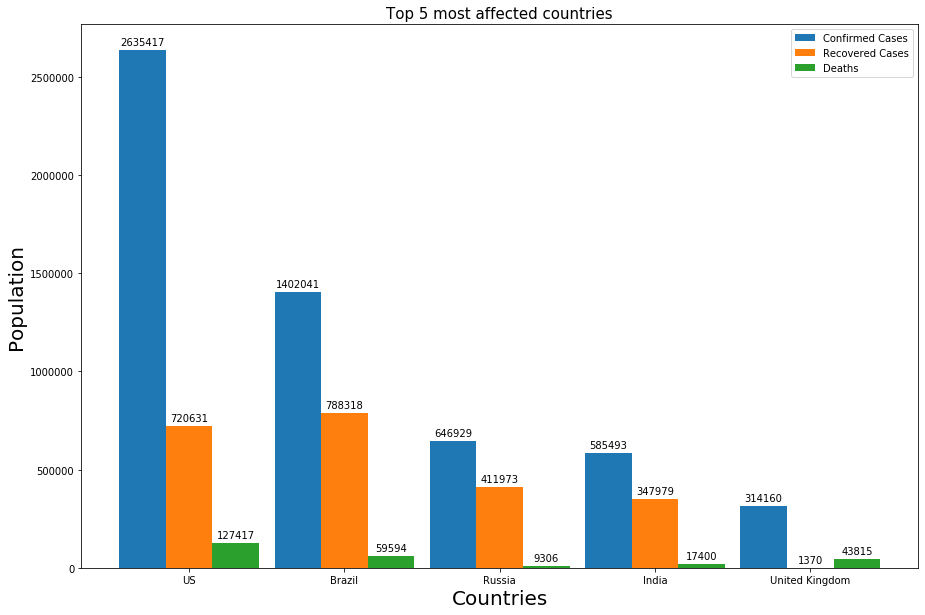

In [163]:

top5 = df_countrywise.sort_values('Confirmed', ascending=False).iloc[:5, :]
labels = top5.index.tolist()
confirmed = top5['Confirmed'].values
deaths = top5['Deaths'].values
recovered = top5['Recovered'].values

x = np.arange(len(labels))
width = 0.30

f, ax = plt.subplots()
f.set_size_inches(15, 10)
bar1 = plt.bar(x - width, confirmed, width, label='Confirmed Cases')
bar2 = plt.bar(x, recovered, width, label='Recovered Cases')
bar3 = plt.bar(x + width, deaths, width, label='Deaths')

ax.ticklabel_format(style='plain')
plt.xticks(x, (labels))
plt.xlabel('Countries', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.title('Top 5 most affected countries', fontsize=15)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.legend()
# plt.savefig('./paper/country-top5-latest.png', bbox_inches='tight')
plt.show()

### Top 5 most affected countries (Trend analysis)

In [164]:
cases = df_global_confirmed.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']]
deaths = df_global_deaths.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']]
recovered = df_global_recovered.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']]

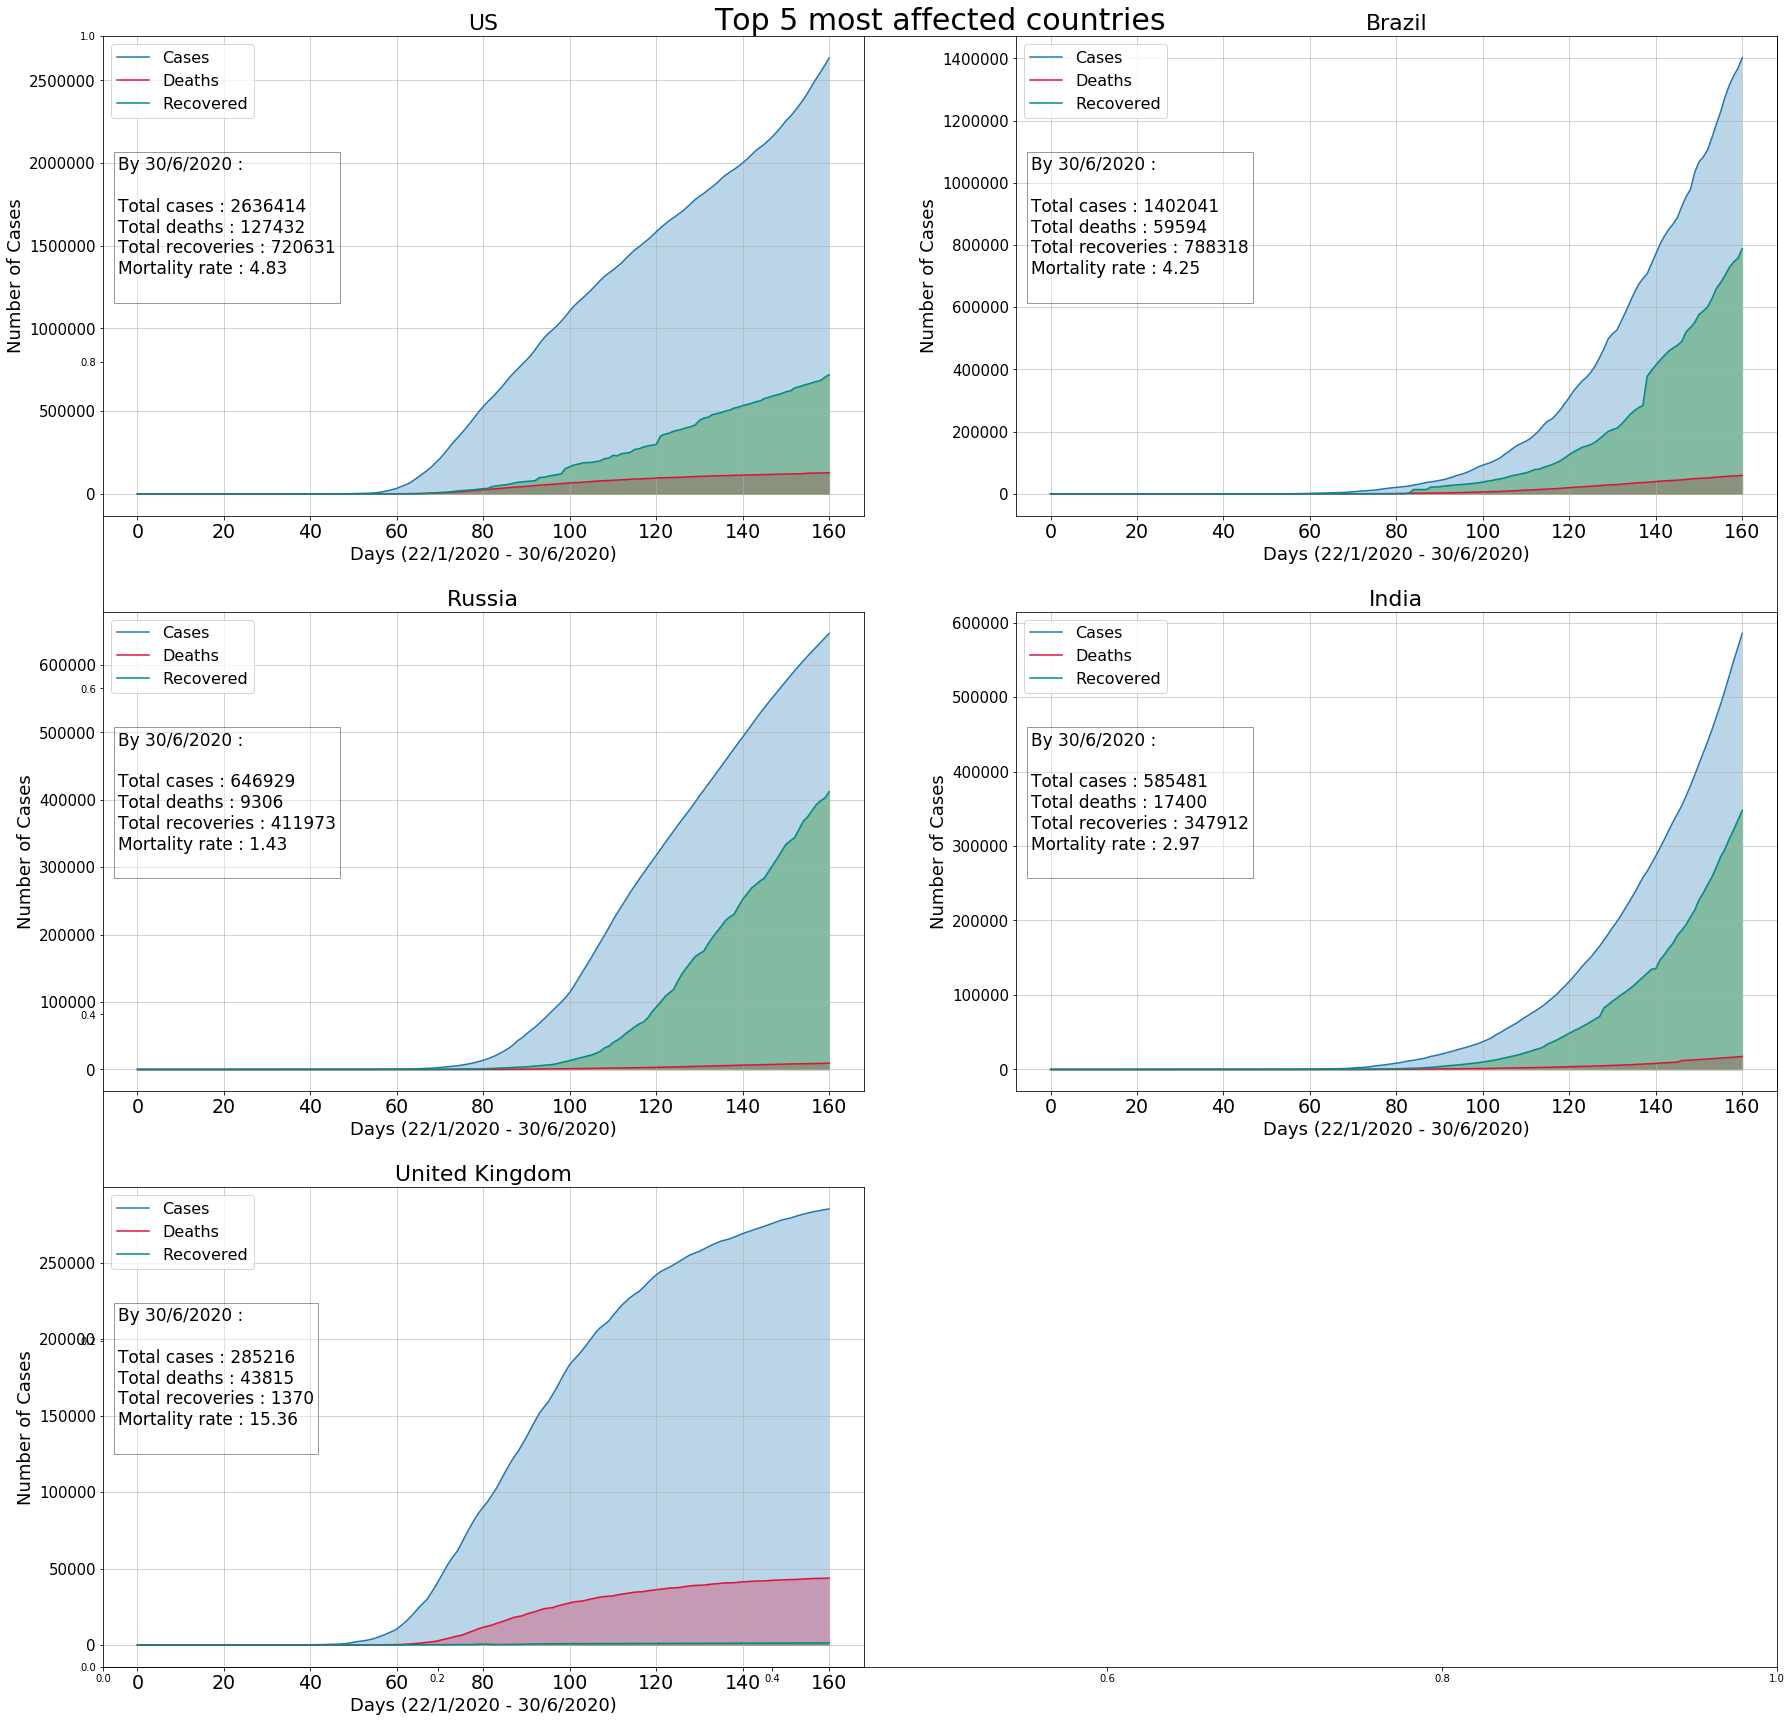

In [165]:
fig = plt.figure(figsize=(30,30))
plt.title("Top 5 most affected countries", size=30)
cols = 2
rows = int(np.ceil(cases.shape[0]/cols))

for i, country in enumerate(cases.index):
    ax = fig.add_subplot(rows, cols, i+1)
    dates = np.arange(cases.shape[1])
    
    plt.plot(dates, cases.loc[country], label="Cases")
    plt.plot(dates, deaths.loc[country], label="Deaths", color="crimson")
    plt.plot(dates, recovered.loc[country], label="Recovered", color="darkcyan")
    
    plt.fill_between(dates, cases.loc[country], alpha=0.3)
    plt.fill_between(dates, deaths.loc[country], alpha=0.3, color='crimson')
    plt.fill_between(dates, recovered.loc[country], alpha=0.3, color='green')
    
    plt.title(country, fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=15)
    plt.xlabel("Days (22/1/2020 - 30/6/2020)", fontsize=18)
    plt.ylabel("Number of Cases", fontsize=18)
    
    text = "By 30/6/2020 : \n\n"
    text += "Total cases : " + str(cases.loc[country][-1]) + "\n"
    text += "Total deaths : " + str(deaths.loc[country][-1]) + "\n"
    text += "Total recoveries : " + str(recovered.loc[country][-1]) + "\n"
    text += "Mortality rate : "+ str(int(deaths.loc[country][-1]/(cases.loc[country][-1])*10000)/100)+"\n"
    plt.text(0.02, 0.75, text, fontsize = 17, horizontalalignment='left', verticalalignment='top',
             transform= ax.transAxes, bbox=dict(facecolor='white', alpha=0.4))
    
    plt.grid(alpha=0.7)
    plt.legend(loc='best', fontsize=16)
    
#     plt.savefig("top5_country_trend.png", bbox_inches='tight')

#     plt.savefig("top5_" + str(i) + ".png", bbox_inches='tight')

plt.show()

#### * very low recovery rate for UK

### Top 5 most affected countries (daily cases)

In [166]:
cases_daily = daywise_data(df_global_confirmed.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']])
deaths_daily = daywise_data(df_global_deaths.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']])
recovered_daily = daywise_data(df_global_recovered.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']])

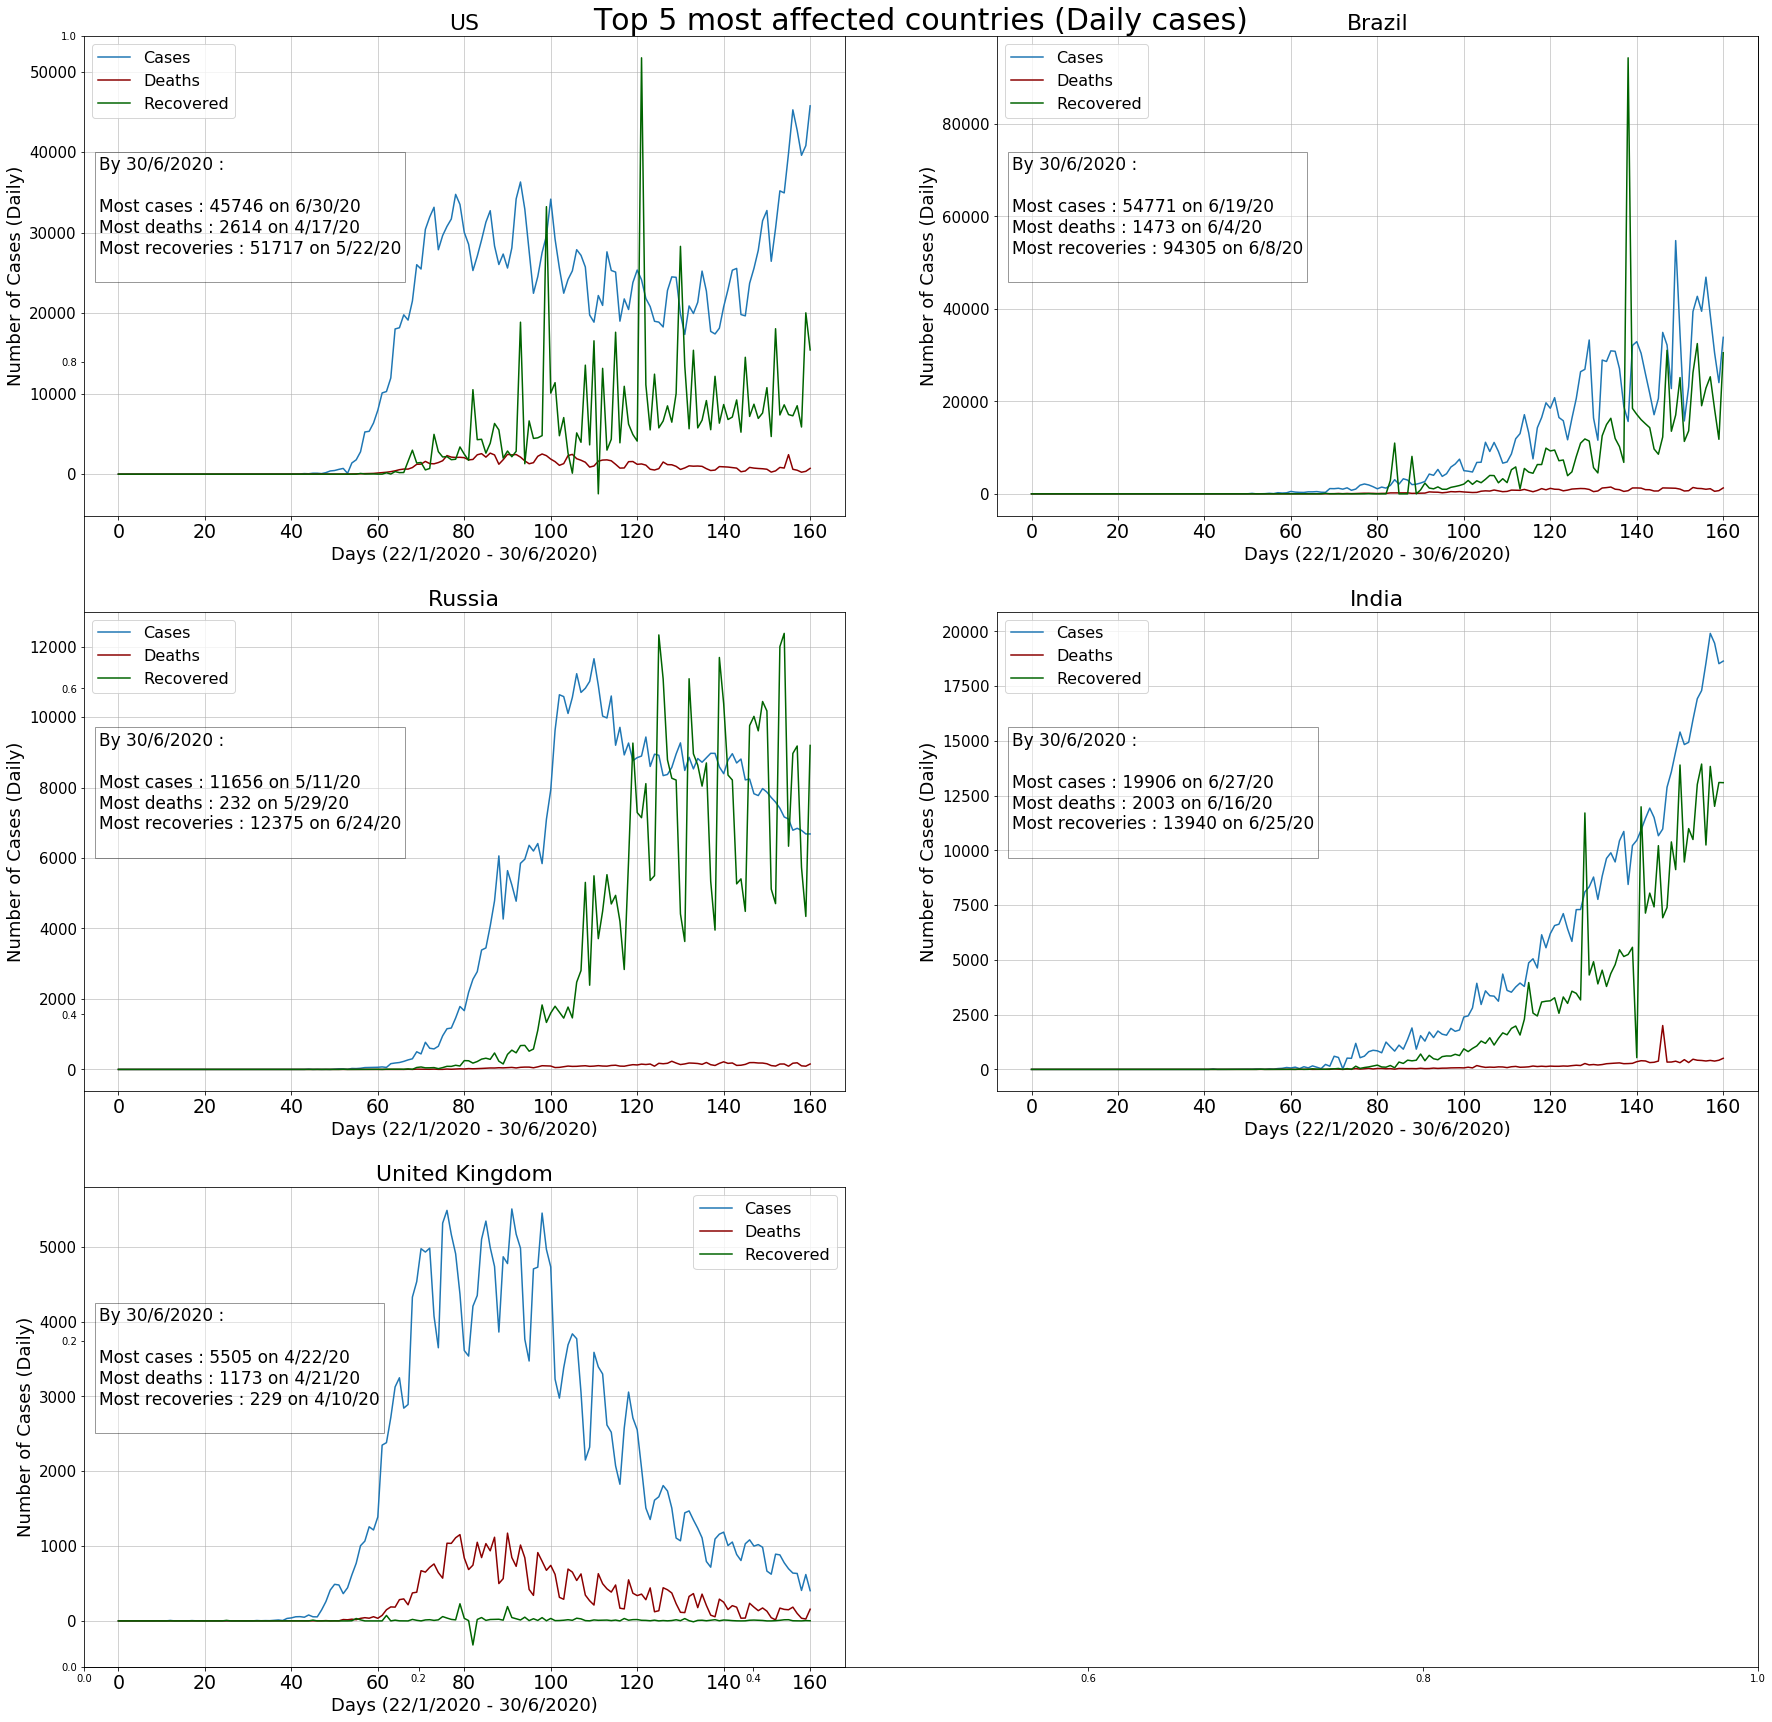

In [167]:
fig = plt.figure(figsize=(30,30))
plt.title("Top 5 most affected countries (Daily cases)", size=30)
cols = 2
rows = int(np.ceil(cases.shape[0]/cols))

for i, country in enumerate(cases.index):
   
    dates = np.arange(cases.shape[1])
    ax = fig.add_subplot(rows, cols, i+1)
    plt.plot(dates, cases_daily.loc[country], label="Cases")
    plt.plot(dates, deaths_daily.loc[country], label="Deaths", color="darkred")
    plt.plot(dates, recovered_daily.loc[country], label="Recovered", color="darkgreen")
    
    plt.title(country, fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=15)
    plt.xlabel("Days (22/1/2020 - 30/6/2020)", fontsize=18)
    plt.ylabel("Number of Cases (Daily)", fontsize=18)
    
    text = "By 30/6/2020 : \n\n"
    text += "Most cases : " + str(cases_daily.loc[country].max()) + " on " + str(cases_daily.keys().tolist()[cases_daily.loc[country].argmax()]) + "\n"
    text += "Most deaths : " + str(deaths_daily.loc[country].max()) + " on " + str(deaths_daily.keys().tolist()[deaths_daily.loc[country].argmax()]) + "\n"
    text += "Most recoveries : " + str(recovered_daily.loc[country].max()) + " on " + str(recovered_daily.keys().tolist()[recovered_daily.loc[country].argmax()]) + "\n"
    plt.text(0.02, 0.75, text, fontsize = 17, horizontalalignment='left', verticalalignment='top',
             transform= ax.transAxes, bbox=dict(facecolor='white', alpha=0.4))
    
    plt.grid(alpha=0.7)
    plt.legend(loc='best', fontsize=16)

#     plt.savefig("top5daily_country.png", bbox_inches='tight')

plt.show()

### Least affected countries

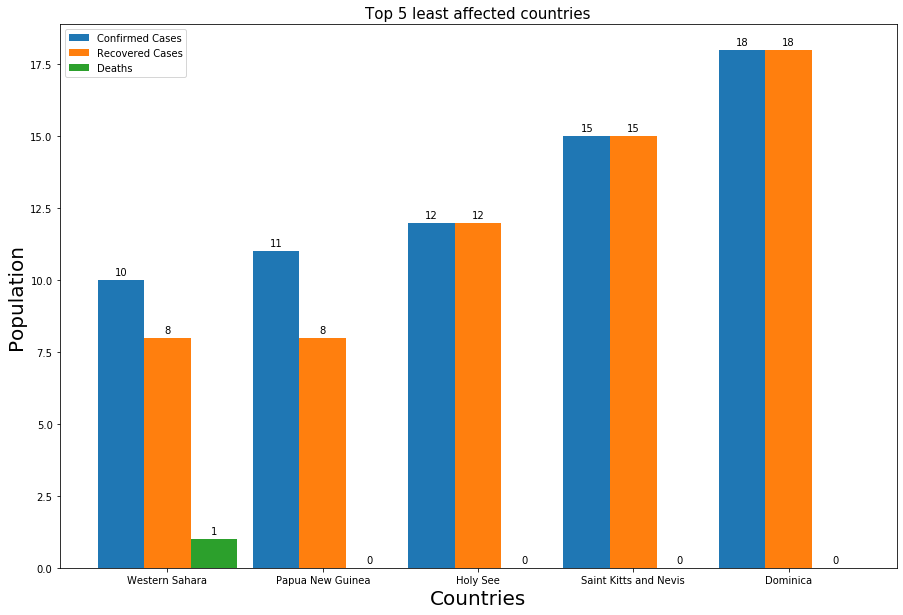

In [168]:
df_countrywise.drop(index = 'MS Zaandam', inplace = True)
bottom5 = df_countrywise.sort_values('Confirmed').iloc[:5, :]
labels = bottom5.index.tolist()
confirmed = bottom5['Confirmed'].values
deaths = bottom5['Deaths'].values
recovered = bottom5['Recovered'].values

x = np.arange(len(labels))
width = 0.30

f, ax = plt.subplots()
f.set_size_inches(15, 10)
bar1 = plt.bar(x - width, confirmed, width, label='Confirmed Cases')
bar2 = plt.bar(x, recovered, width, label='Recovered Cases')
bar3 = plt.bar(x + width, deaths, width, label='Deaths')

ax.ticklabel_format(style='plain')
plt.xticks(x, (labels))
plt.xlabel('Countries', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.title('Top 5 least affected countries', fontsize=15)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.legend()
# plt.savefig('./paper/countries-bottom5-latest.png', bbox_inches='tight')
plt.show()

### Top 5 least affected countries

In [169]:

cases_least = df_global_confirmed.groupby('Country').sum().loc[df_countrywise.sort_values('Confirmed')["Confirmed"].index[:5]]
deaths_least = df_global_deaths.groupby('Country').sum().loc[df_countrywise.sort_values('Confirmed')["Confirmed"].index[:5]]
recovered_least = df_global_recovered.groupby('Country').sum().loc[df_countrywise.sort_values('Confirmed')["Confirmed"].index[:5]]

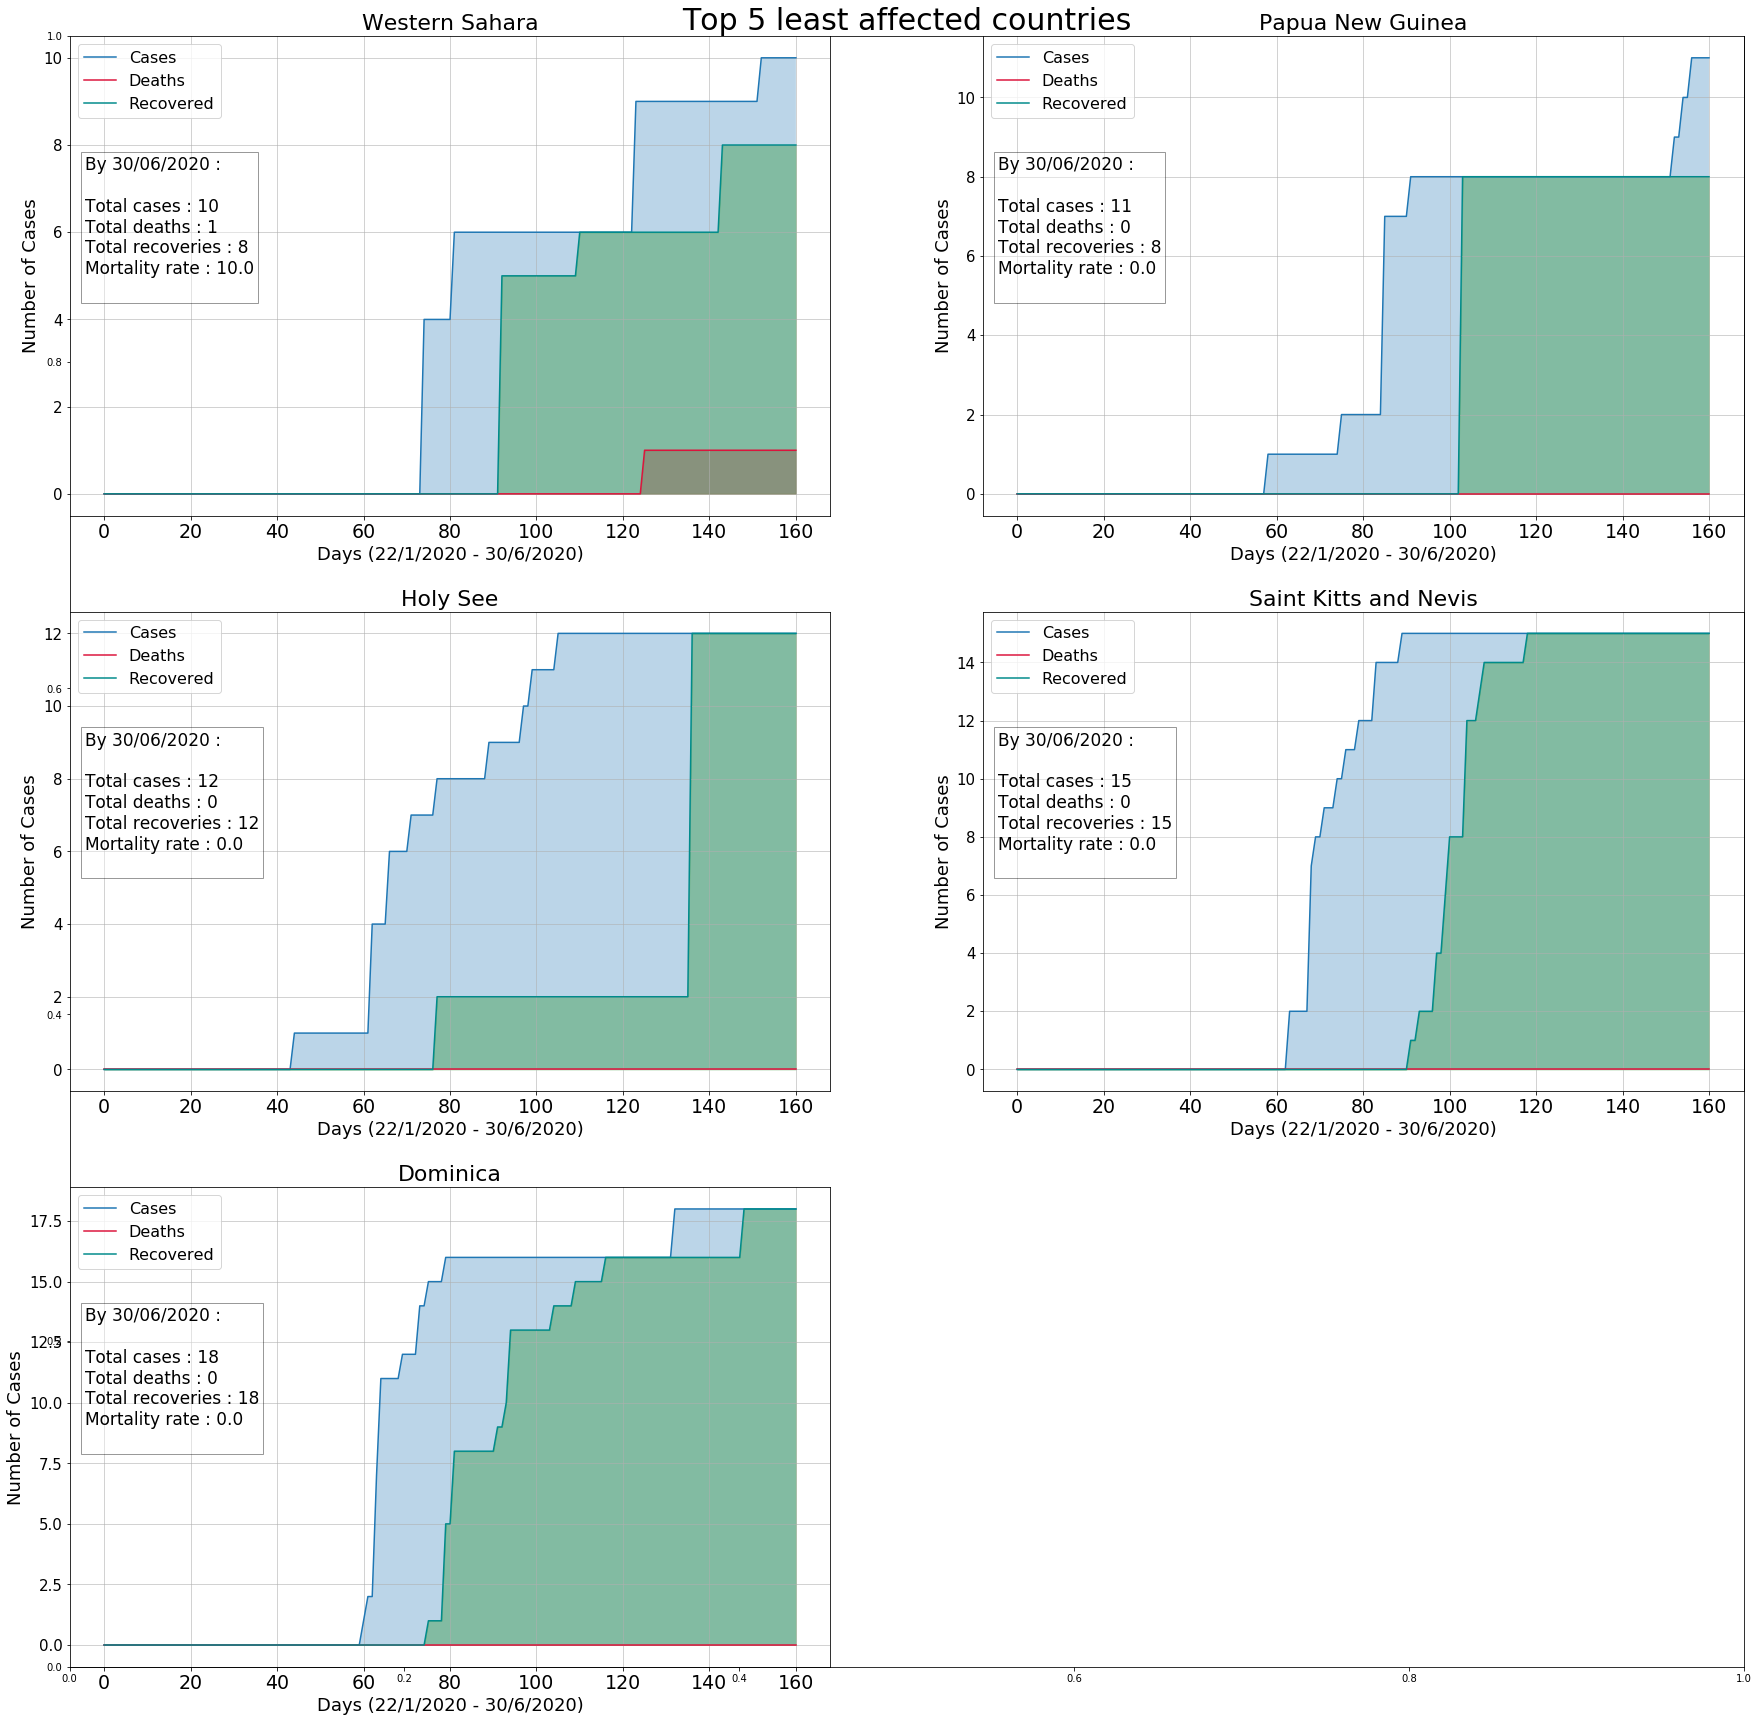

In [170]:
fig = plt.figure(figsize=(30,30))
plt.title("Top 5 least affected countries", size=30)
cols = 2
rows = int(np.ceil(cases_least.shape[0]/cols))

for i, country in enumerate(cases_least.index):
    ax = fig.add_subplot(rows, cols, i+1)
    dates = np.arange(cases_least.shape[1])
    
    plt.plot(dates, cases_least.loc[country], label="Cases")
    plt.plot(dates, deaths_least.loc[country], label="Deaths", color="crimson")
    plt.plot(dates, recovered_least.loc[country], label="Recovered", color="darkcyan")
    
    plt.fill_between(dates, cases_least.loc[country], alpha=0.3)
    plt.fill_between(dates, deaths_least.loc[country], alpha=0.3, color='crimson')
    plt.fill_between(dates, recovered_least.loc[country], alpha=0.3, color='green')
    
    plt.title(country, fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=15)
    plt.xlabel("Days (22/1/2020 - 30/6/2020)", fontsize=18)
    plt.ylabel("Number of Cases", fontsize=18)
    
    text = "By 30/06/2020 : \n\n"
    text += "Total cases : " + str(cases_least.loc[country][-1]) + "\n"
    text += "Total deaths : " + str(deaths_least.loc[country][-1]) + "\n"
    text += "Total recoveries : " + str(recovered_least.loc[country][-1]) + "\n"
    text += "Mortality rate : "+ str(int(deaths_least.loc[country][-1]/(cases_least.loc[country][-1])*10000)/100)+"\n"
    plt.text(0.02, 0.75, text, fontsize = 17, horizontalalignment='left', verticalalignment='top',
             transform= ax.transAxes, bbox=dict(facecolor='white', alpha=0.4))
    
    plt.grid(alpha=0.7)
    plt.legend(loc='best', fontsize=16)

#     plt.savefig("./paper/bottom5_trend_country.png", bbox_inches='tight')

plt.show()

### Top 5 least affected countries ( daily analysis )

In [171]:
cases_daily_least = daywise_data(df_global_confirmed.groupby('Country').sum().loc[['Western Sahara', 'Papua New Guinea', 'Holy See', 'Saint Kitts and Nevis', 'Dominica']])
deaths_daily_least = daywise_data(df_global_deaths.groupby('Country').sum().loc[['Western Sahara', 'Papua New Guinea', 'Holy See', 'Saint Kitts and Nevis', 'Dominica']])
recovered_daily_least = daywise_data(df_global_recovered.groupby('Country').sum().loc[['Western Sahara', 'Papua New Guinea', 'Holy See', 'Saint Kitts and Nevis', 'Dominica']])

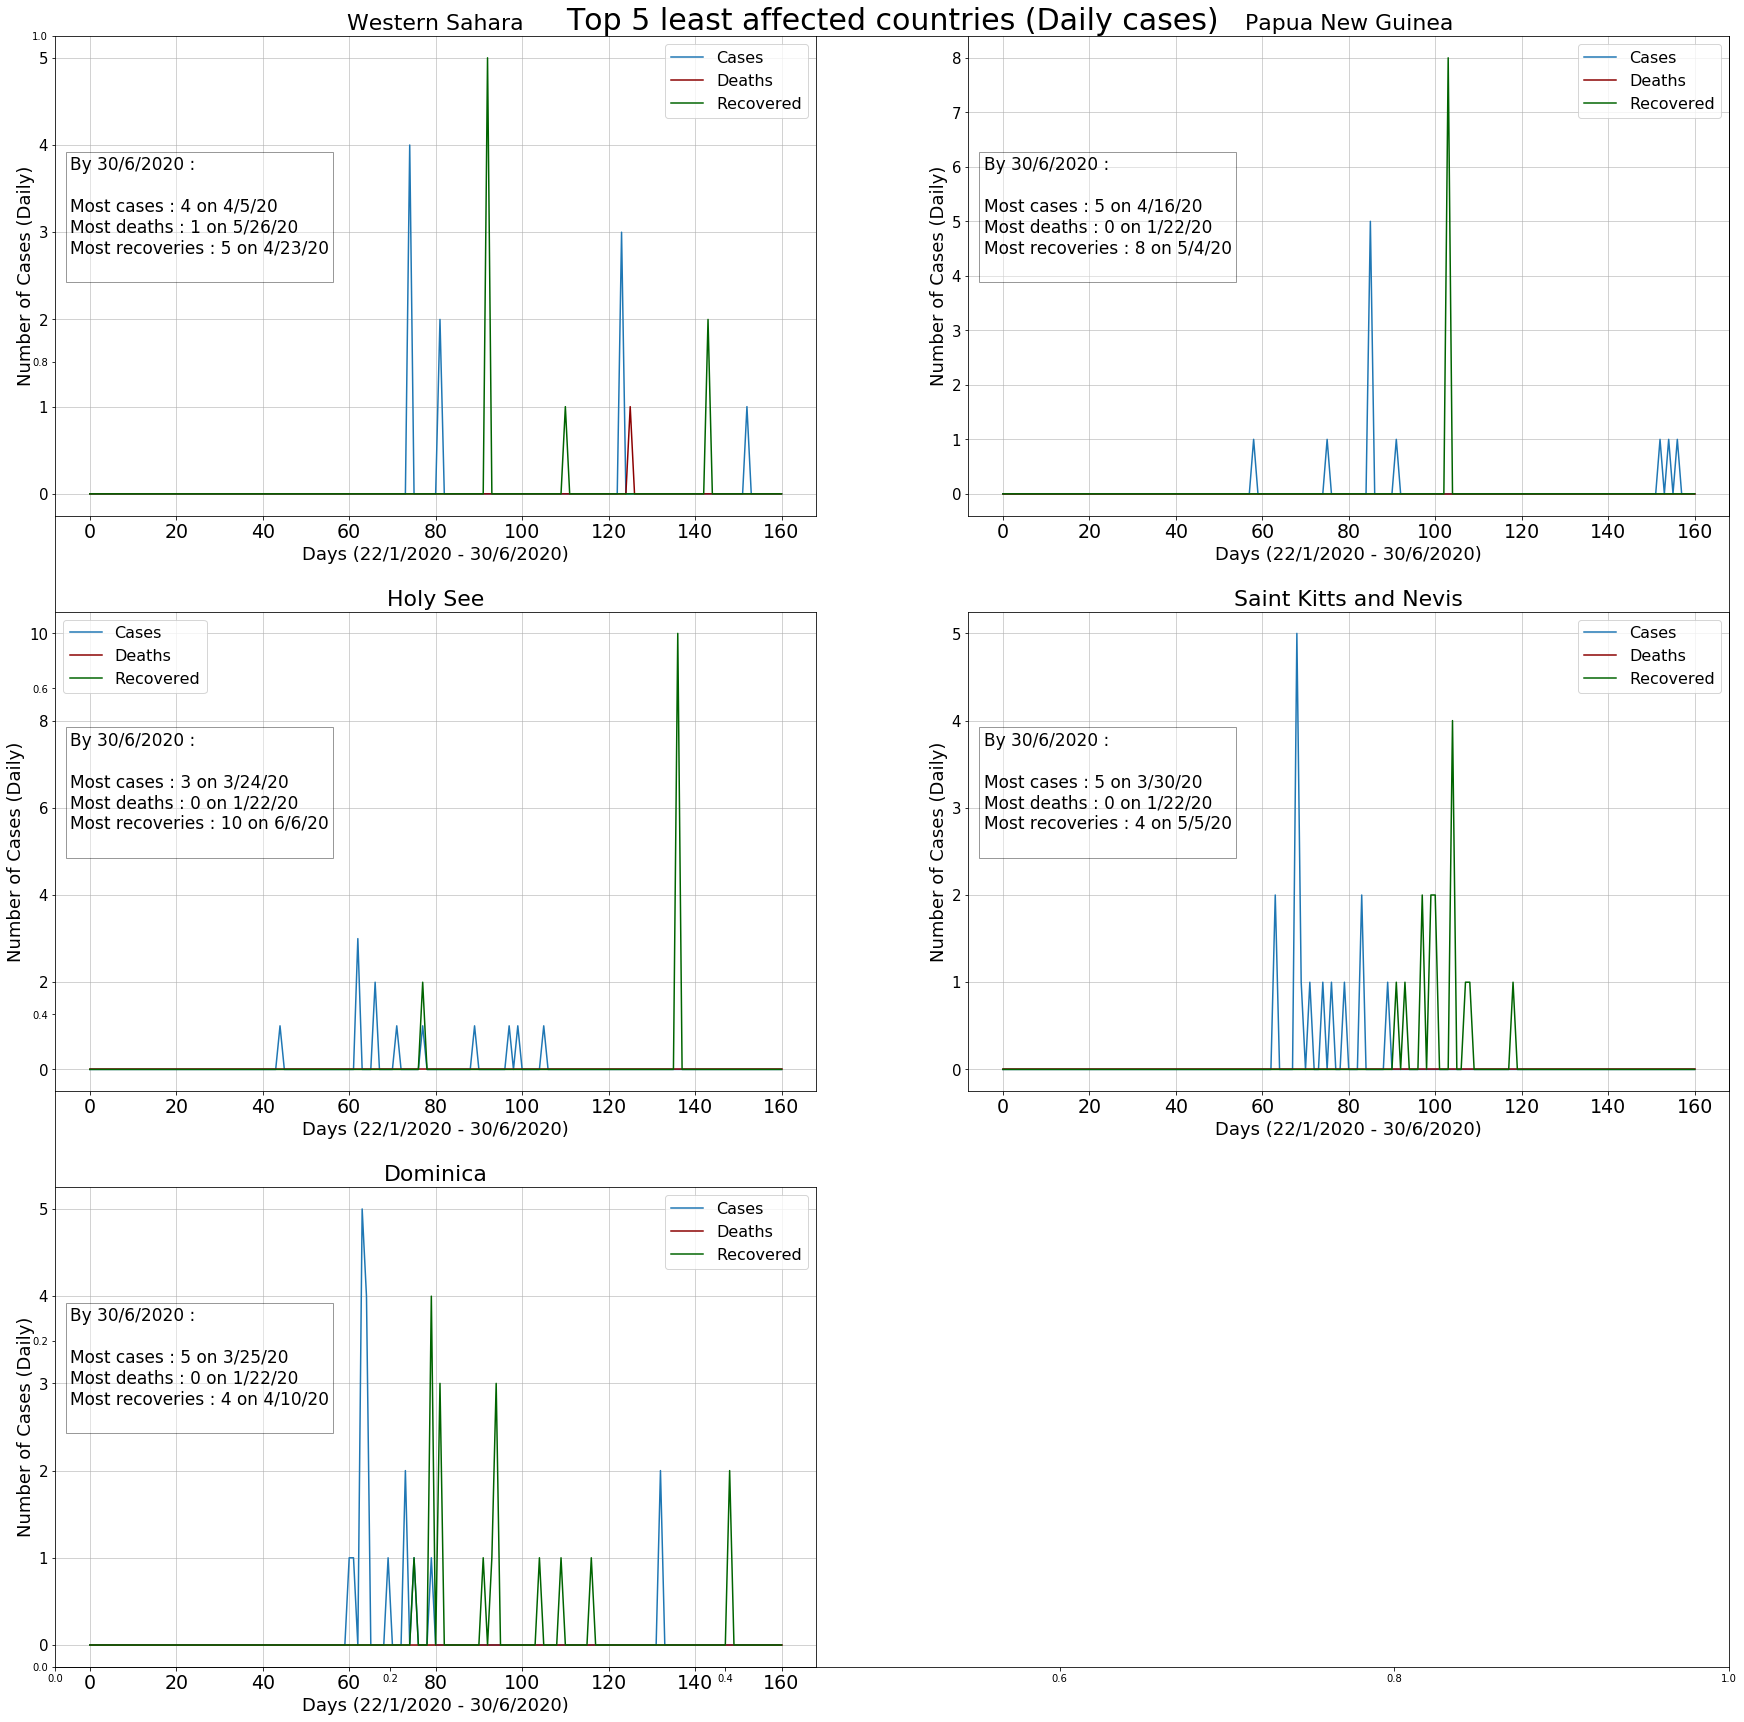

In [172]:
fig = plt.figure(figsize=(30,30))
plt.title("Top 5 least affected countries (Daily cases)", size=30)
cols = 2
rows = int(np.ceil(cases_daily_least.shape[0]/cols))

for i, country in enumerate(cases_daily_least.index):
    ax = fig.add_subplot(rows, cols, i+1)
    dates = np.arange(cases_daily_least.shape[1])
    
    plt.plot(dates, cases_daily_least.loc[country], label="Cases")
    plt.plot(dates, deaths_daily_least.loc[country], label="Deaths", color="darkred")
    plt.plot(dates, recovered_daily_least.loc[country], label="Recovered", color="darkgreen")
    
    plt.title(country, fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=15)
    plt.xlabel("Days (22/1/2020 - 30/6/2020)", fontsize=18)
    plt.ylabel("Number of Cases (Daily)", fontsize=18)
    
    text = "By 30/6/2020 : \n\n"
    text += "Most cases : " + str(cases_daily_least.loc[country].max()) + " on " + str(cases_daily_least.keys().tolist()[cases_daily_least.loc[country].argmax()]) + "\n"
    text += "Most deaths : " + str(deaths_daily_least.loc[country].max()) + " on " + str(deaths_daily_least.keys().tolist()[deaths_daily_least.loc[country].argmax()]) + "\n"
    text += "Most recoveries : " + str(recovered_daily_least.loc[country].max()) + " on " + str(recovered_daily_least.keys().tolist()[recovered_daily_least.loc[country].argmax()]) + "\n"
    plt.text(0.02, 0.75, text, fontsize = 17, horizontalalignment='left', verticalalignment='top',
             transform= ax.transAxes, bbox=dict(facecolor='white', alpha=0.4))
    
    plt.grid(alpha=0.7)
    plt.legend(loc='best', fontsize=16)

#     plt.savefig("./paper/bottom5_daily.png", bbox_inches = 'tight')

plt.show()

### Testing Analysis for top 5 most affected countries

In [173]:
# preprocessing the country names
df_test['Country'] = [c.split("-")[0].strip() for c in df_test['Entity'].values]

In [174]:
# filtering the dates

start_date = "2020-01-01"
end_date = "2020-06-30"

after_start_date = df_test['Date'] >= start_date
before_end_date = df_test['Date'] <= end_date
between_two_dates = after_start_date & before_end_date
df_test = df_test.loc[between_two_dates]

In [175]:
df_test = df_test.sort_values('Cumulative total', ascending = False).groupby('Country').first().sort_values('Cumulative total', ascending = False)

df_test["Cumulative total per million"] = df_test["Cumulative total per thousand"]*1000
df_test = df_test.drop(["Cumulative total per thousand"],axis=1)

df_test_top = df_test.loc[['United States', 'Brazil', 'Russia', 'India', 'United Kingdom']]
df_test_top['Confirmed'] = df_countrywise.loc[['US','Brazil','Russia','India','United Kingdom']]['Confirmed'].reset_index().drop(['Country_Region'], axis=1).values
df_test_top["Positive"] = np.round(100*df_test_top["Confirmed"]/df_test_top["Cumulative total"],2)

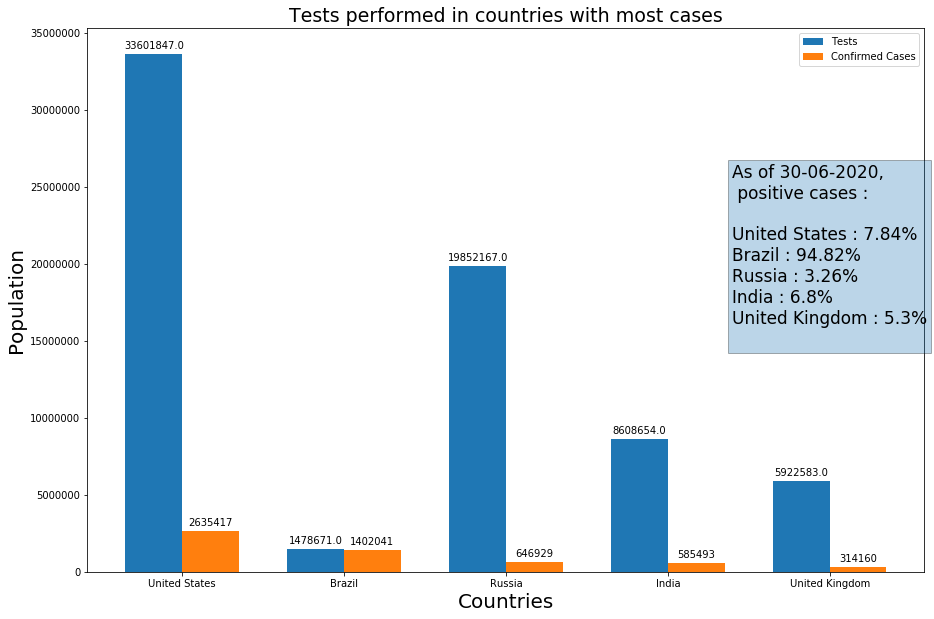

In [176]:
labels = df_test_top.index.tolist()
tests = df_test_top['Cumulative total'].values
cases = df_test_top['Confirmed'].values

x = np.arange(len(labels))
width = 0.35

f, ax = plt.subplots()
f.set_size_inches(15, 10)
bar1 = plt.bar(x - width/2, tests, width, label='Tests')
bar2 = plt.bar(x + width/2, cases, width, label='Confirmed Cases')

text = 'As of 30-06-2020,\n positive cases : \n\n'
for country in labels:
    text += country + ' : ' + str(df_test_top.loc[country]['Positive']) + '%\n'
plt.text(0.77, 0.75, text, fontsize = 17, horizontalalignment='left', verticalalignment='top',
             transform= ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', alpha=0.3))
ax.ticklabel_format(style='plain')
plt.xticks(x, (df_test_top.index.tolist()))
plt.xlabel('Countries', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.title('Tests performed in countries with most cases', fontsize=19)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.legend()
# plt.savefig('testing-top5.png', bbox_inches='tight')
plt.show()

### Stringency Index analysis for top 5 most affected countries

In [177]:
response = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')


In [178]:
response.head()

CountryName CountryCode      Date  C1_School closing  C1_Flag  \
0       Aruba         ABW  20200101                0.0      NaN   
1       Aruba         ABW  20200102                0.0      NaN   
2       Aruba         ABW  20200103                0.0      NaN   
3       Aruba         ABW  20200104                0.0      NaN   
4       Aruba         ABW  20200105                0.0      NaN   

   C2_Workplace closing  C2_Flag  C3_Cancel public events  C3_Flag  \
0                   0.0      NaN                      0.0      NaN   
1                   0.0      NaN                      0.0      NaN   
2                   0.0      NaN                      0.0      NaN   
3                   0.0      NaN                      0.0      NaN   
4                   0.0      NaN                      0.0      NaN   

   C4_Restrictions on gatherings  ...  StringencyIndex  \
0                            0.0  ...              0.0   
1                            0.0  ...              0.0   
2                            0.0  ...              0.0   
3                            0.0  ...              0.0   
4                            0.0  ...              0.0   

   StringencyIndexForDisplay  StringencyLegacyIndex  \
0                        0.0                    0.0   
1                        0.0                    0.0   
2                        0.0                    0.0   
3                        0.0                    0.0   
4                        0.0                    0.0   

   StringencyLegacyIndexForDisplay  GovernmentResponseIndex  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   
3                              0.0                      0.0   
4                              0.0                      0.0   

   GovernmentResponseIndexForDisplay  ContainmentHealthIndex  \
0                                0.0                     0.0   
1                                0.0                     0.0   
2                                0.0                     0.0   
3                                0.0                     0.0   
4                                0.0                     0.0   

   ContainmentHealthIndexForDisplay  EconomicSupportIndex  \
0                               0.0                   0.0   
1                               0.0                   0.0   
2                               0.0                   0.0   
3                               0.0                   0.0   
4                               0.0                   0.0   

   EconomicSupportIndexForDisplay  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  

[5 rows x 42 columns]

In [179]:
response = response[['CountryName', 'Date', 'StringencyIndex', 'StringencyIndexForDisplay', 'StringencyLegacyIndex',
                     'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex', 
                     'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex', 
                     'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex', 'EconomicSupportIndexForDisplay']]

In [180]:
dates = []
for date in response['Date']:
    date = str(date)
    year, month, day = date[:4], date[4:6], date[6:]
    dates.append(year + '-' + month + '-' + day)
    
response['Date'] = dates

In [181]:
start_date = "2020-01-01"
end_date = "2020-06-30"

after_start_date = response['Date'] >= start_date
before_end_date = response['Date'] <= end_date
between_two_dates = after_start_date & before_end_date
response = response.loc[between_two_dates]

In [182]:
response.rename({'CountryName':'Country', 'StringencyIndex':'Stringency Index'}, axis='columns', inplace=True)

In [183]:
response_top = response.groupby('Country').last().loc[['United States','Brazil','Russia','India','United Kingdom']]

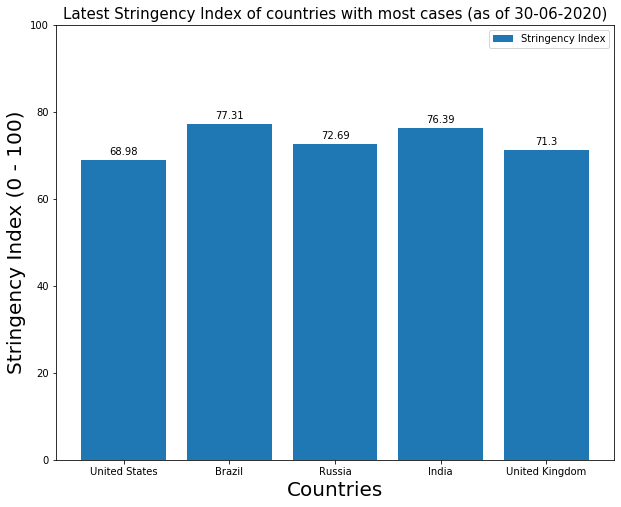

In [184]:
labels = response_top.index.tolist()
SI = response_top['Stringency Index'].values

x = np.arange(len(labels))
width = 0.05

f, ax = plt.subplots()
f.set_size_inches(10, 8)
bar1 = plt.bar(x, SI, label='Stringency Index')

ax.ticklabel_format(style='plain')
ax.set_ylim([0,100])
plt.xticks(x, (response_top.index.tolist()))
plt.xlabel('Countries', fontsize=20)
plt.ylabel('Stringency Index (0 - 100)', fontsize=20)
plt.title('Latest Stringency Index of countries with most cases (as of 30-06-2020)', fontsize=15)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)

plt.legend()
# plt.savefig('stringency_latest.png', bbox_inches='tight')
plt.show()

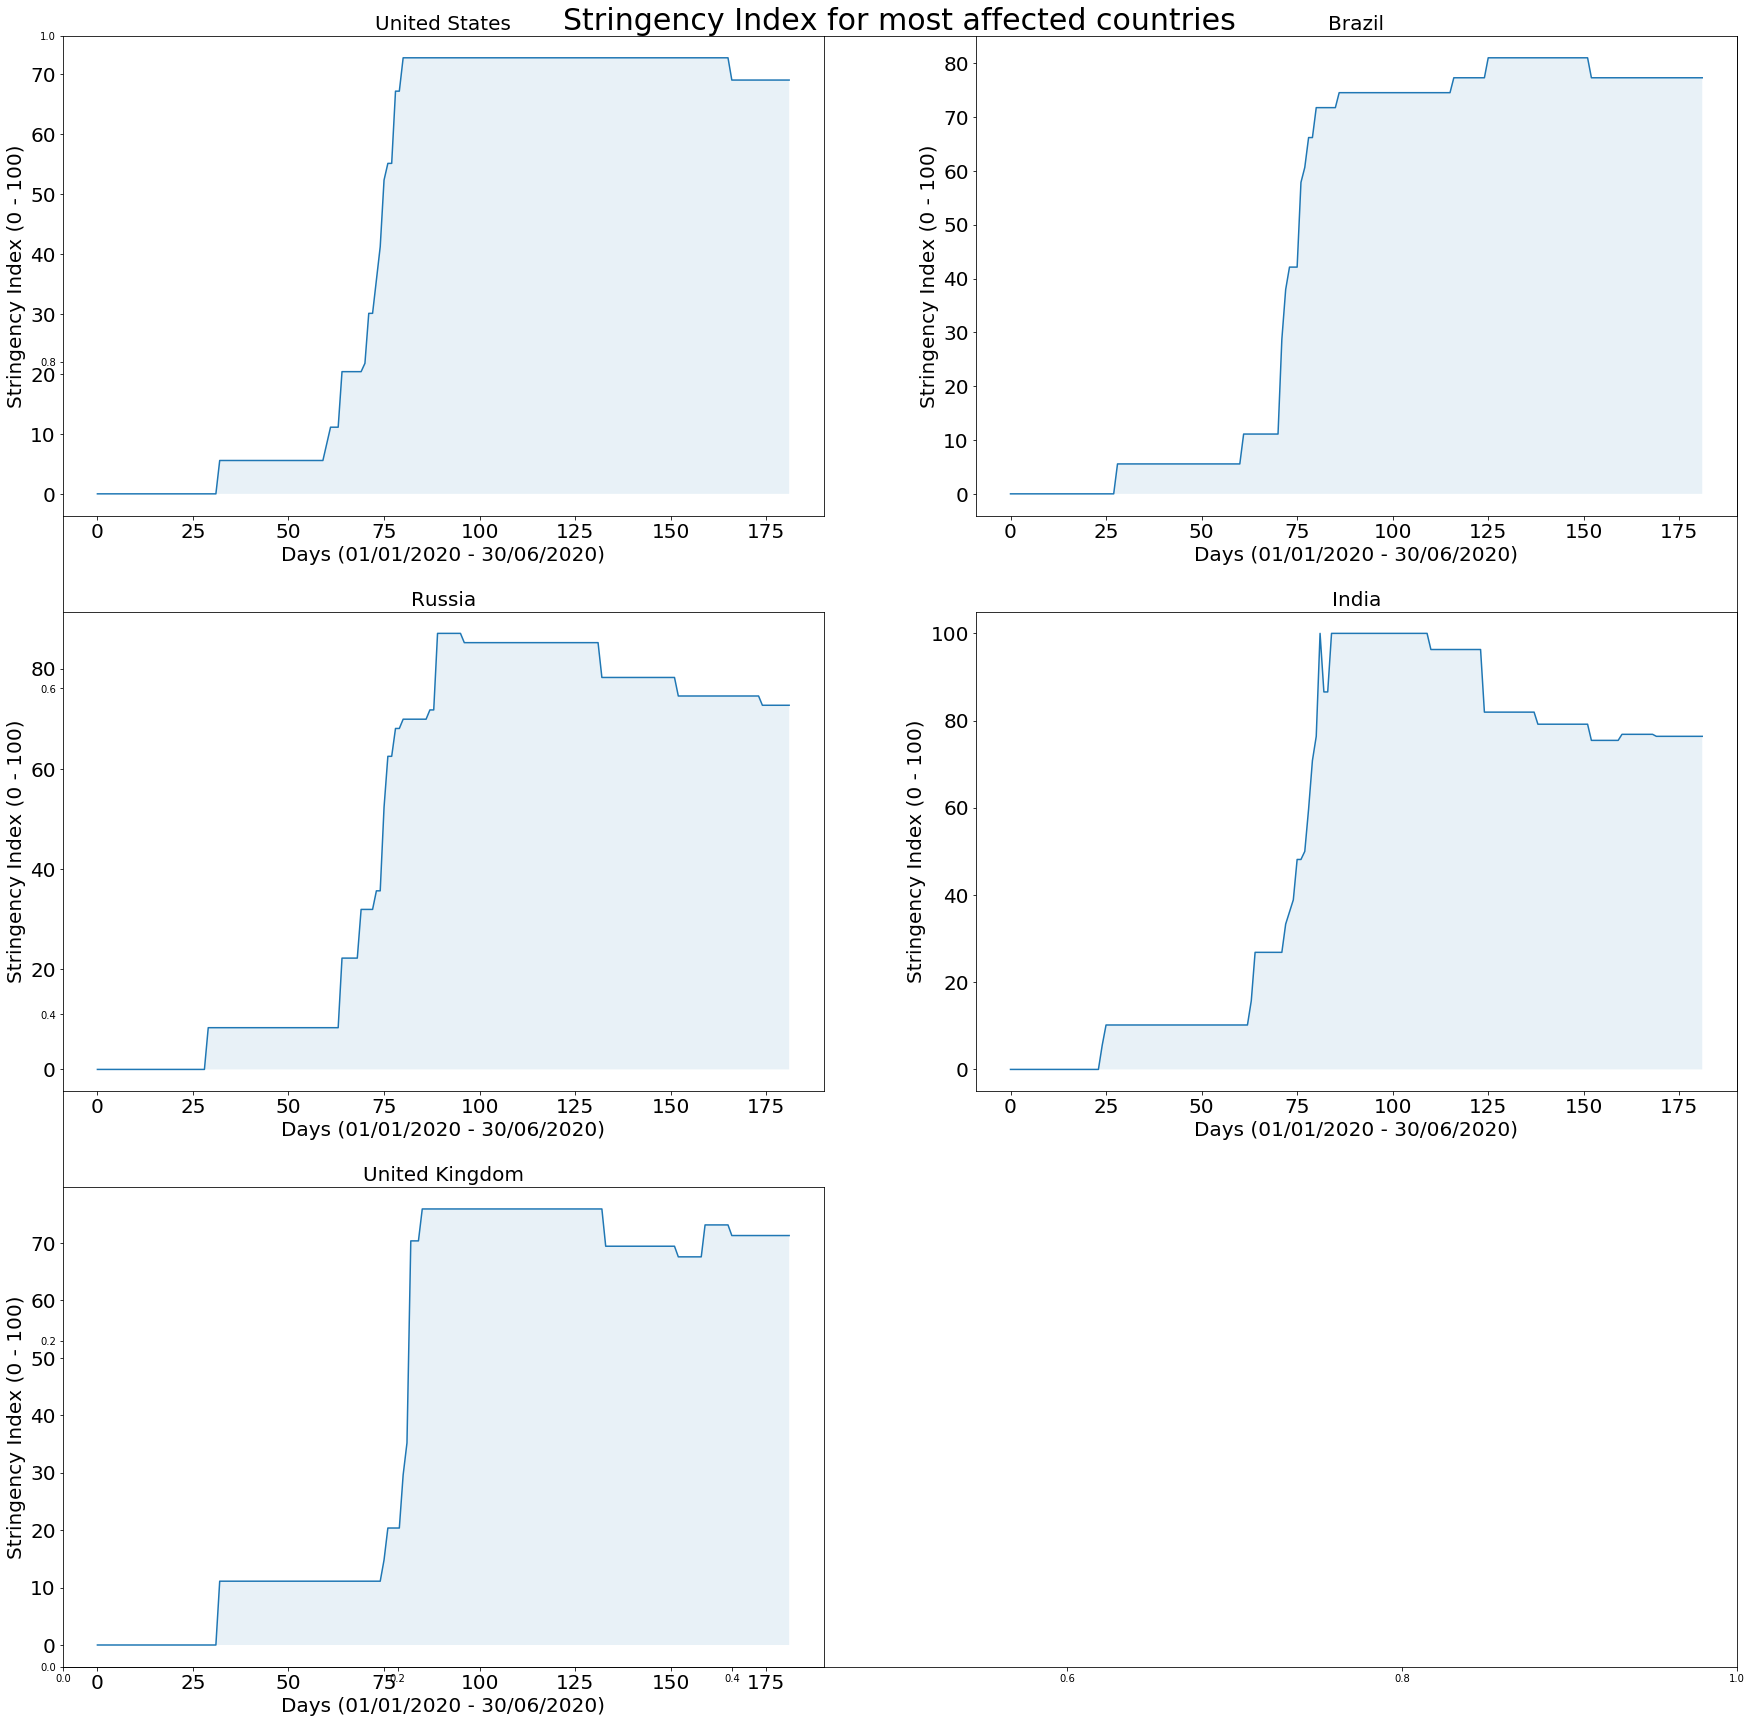

In [185]:
fig = plt.figure(figsize=(30,30))
plt.title("Stringency Index for most affected countries", size=30)
cols = 2
rows = 3

for i, country in enumerate(['United States', 'Brazil', 'Russia', 'India', 'United Kingdom']):
    df = response.set_index('Country').loc[country]
    days = np.arange(df['Date'].shape[0])
    ax = fig.add_subplot(rows, cols, i+1)
    plt.plot(days,df['Stringency Index'].values, label = 'Stringency Index')
    plt.fill_between(days, df['Stringency Index'].values, alpha=0.1)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(country, fontsize=20)
    plt.xlabel('Days (01/01/2020 - 30/06/2020)', fontsize=20)
    plt.ylabel('Stringency Index (0 - 100)', fontsize=20)
#     plt.savefig('./paper/stringency_ts_most_affected.png', bbox_inches='tight')

plt.show()

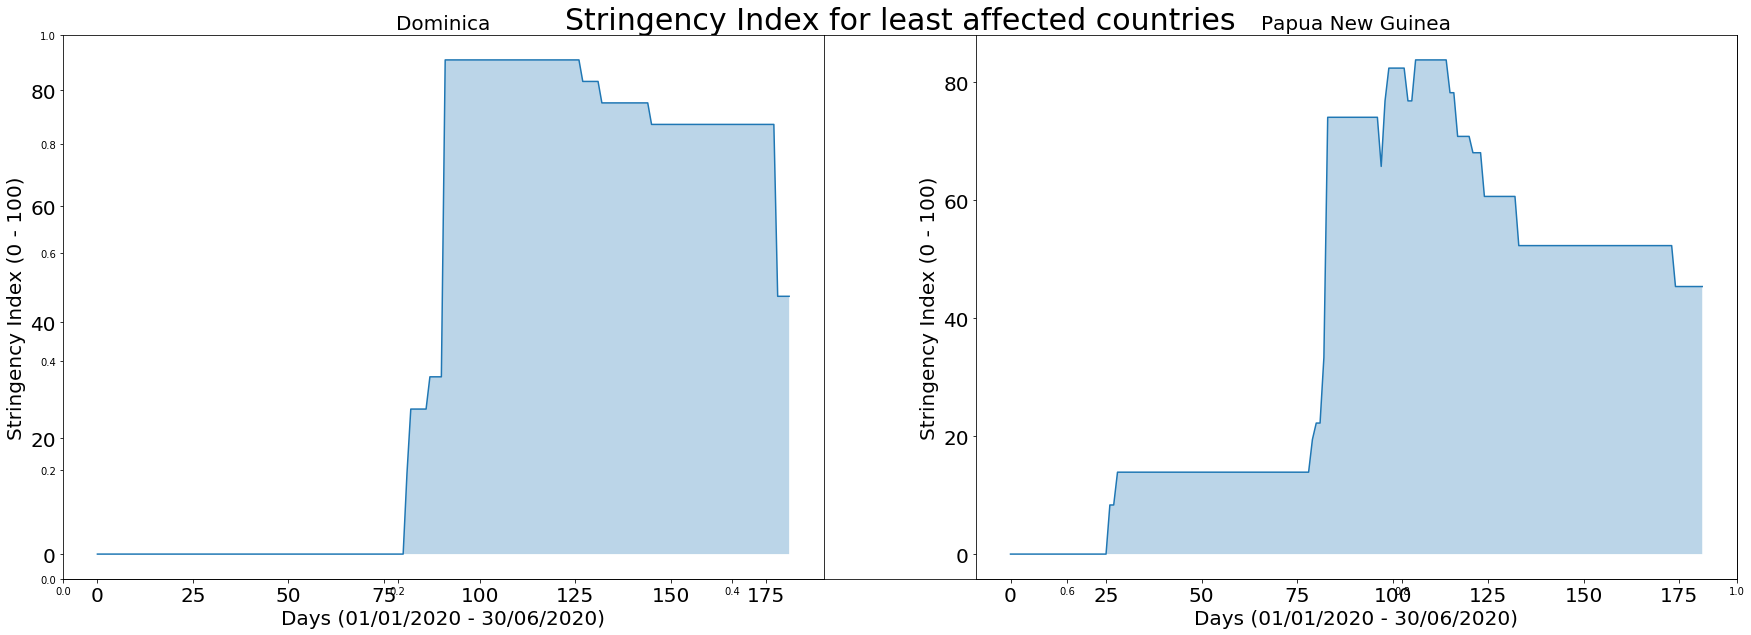

In [186]:
fig = plt.figure(figsize=(30,10))
plt.title("Stringency Index for least affected countries", size=30)
cols = 2
rows = 1

for i, country in enumerate(['Dominica', 'Papua New Guinea']):
    ax = fig.add_subplot(rows, cols, i+1)
    df = response.set_index('Country').loc[country]
    days = np.arange(df['Date'].shape[0])
    
    plt.plot(days,df['Stringency Index'].values, label = 'Stringency Index')
    plt.fill_between(days, df['Stringency Index'].values, alpha=0.3)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(country, fontsize=20)
    plt.xlabel('Days (01/01/2020 - 30/06/2020)', fontsize=20)
    plt.ylabel('Stringency Index (0 - 100)', fontsize=20)
#     plt.savefig('stringency-bottom' + str(i) + '.png', bbox_inches='tight')

plt.show()

## Covid-19 Analysis : India

### Data preprocessing

In [187]:
data = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise/history').json()
data['data']['history']

[{'day': '2020-03-14',
  'total': {'confirmed': 81, 'recovered': 9, 'deaths': 2, 'active': 70},
  'statewise': [{'state': 'Andaman and Nicobar Islands',
    'confirmed': 0,
    'recovered': 0,
    'deaths': 0,
    'active': 0},
   {'state': 'Andhra Pradesh',
    'confirmed': 1,
    'recovered': 0,
    'deaths': 0,
    'active': 1},
   {'state': 'Arunachal Pradesh',
    'confirmed': 0,
    'recovered': 0,
    'deaths': 0,
    'active': 0},
   {'state': 'Assam',
    'confirmed': 0,
    'recovered': 0,
    'deaths': 0,
    'active': 0},
   {'state': 'Bihar',
    'confirmed': 0,
    'recovered': 0,
    'deaths': 0,
    'active': 0},
   {'state': 'Chandigarh',
    'confirmed': 0,
    'recovered': 0,
    'deaths': 0,
    'active': 0},
   {'state': 'Chhattisgarh',
    'confirmed': 0,
    'recovered': 0,
    'deaths': 0,
    'active': 0},
   {'state': 'Daman and Diu',
    'confirmed': 0,
    'recovered': 0,
    'deaths': 0,
    'active': 0},
   {'state': 'Delhi',
    'confirmed': 7,
    'recov

In [188]:
# Converting from JSON to Pandas Dataframe

df_states = pd.DataFrame(index=[0])
for i, _ in enumerate(data['data']['history']):
    df = pd.json_normalize(data['data']['history'][i]['statewise'])
    df['date'] = [data['data']['history'][i]['day']]*len(data['data']['history'][i]['statewise'])

    df_states = df_states.append(df, ignore_index=True)

df_states = df_states.iloc[1:].reset_index().drop('index', axis=1)


In [189]:
# filtering the dates

start_date = "2020-01-01"
end_date = "2020-06-30"

after_start_date = df_states['date'] >= start_date
before_end_date = df_states['date'] <= end_date
between_two_dates = after_start_date & before_end_date
df_states = df_states.loc[between_two_dates]

df_states.tail(3)

state  confirmed  recovered  deaths  active  \
4028  Andaman and Nicobar Islands       97.0       45.0     0.0    52.0   
4029                    Meghalaya       53.0       42.0     1.0    10.0   
4030                  Lakshadweep        0.0        0.0     0.0     0.0   

            date  
4028  2020-06-30  
4029  2020-06-30  
4030  2020-06-30

In [190]:
# getting latest values
df_india = pd.DataFrame(index=[0])
for entry in data['data']['history']:
    if entry['day'] == '2020-06-30':
        df_india = pd.json_normalize(entry['total'])
        break
        
df_india


confirmed  recovered  deaths  active
0     585792     347839   17410  220477

In [191]:
df_india['mortality rate'] = np.round(100 * (df_india['deaths'] / df_india['confirmed']), 2)
df_india['recovery rate'] = np.round(100 * (df_india['recovered'] / df_india['confirmed']), 2)
df_india['percent active'] = np.round(100 * (df_india['active'] / df_india['confirmed']), 2)
df_india

confirmed  recovered  deaths  active  mortality rate  recovery rate  \
0     585792     347839   17410  220477            2.97          59.38   

   percent active  
0           37.64

### Visualizing Total numbers for India

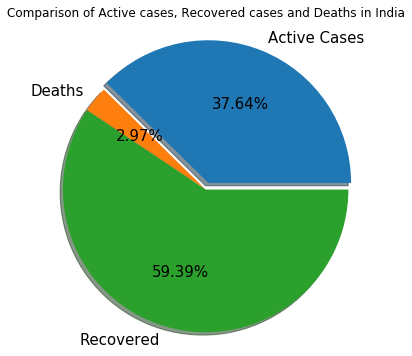

In [192]:
labels = 'Active Cases', 'Deaths', 'Recovered'
explode = [0.05, 0, 0]
sizes = [df_india['percent active'], df_india['mortality rate'], df_india['recovery rate']]
textprops = {"fontsize":15}

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%', shadow = True, textprops = textprops)
ax.axis('equal')
plt.title('Comparison of Active cases, Recovered cases and Deaths in India')
# plt.savefig('india-pie.png', bbox_inches='tight')
plt.show()

### Visualizing Trends

In [193]:
# Reinitializing the values for global cases, deaths, recoveries to filter out India from it

cases = df_global_confirmed.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']]
deaths = df_global_deaths.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']]
recovered = df_global_recovered.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']]

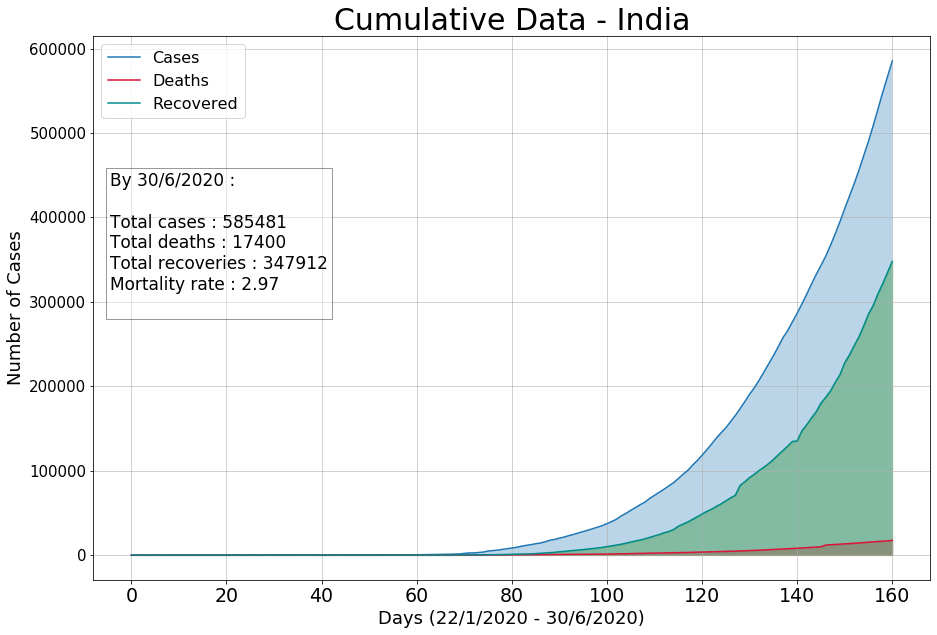

In [194]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title("Cumulative Data - India", size=30)

dates = np.arange(cases.shape[1])

plt.plot(dates, cases.loc['India'], label="Cases")
plt.plot(dates, deaths.loc['India'], label="Deaths", color="crimson")
plt.plot(dates, recovered.loc['India'], label="Recovered", color="darkcyan")

plt.fill_between(dates, cases.loc['India'], alpha=0.3)
plt.fill_between(dates, deaths.loc['India'], alpha=0.3, color='crimson')
plt.fill_between(dates, recovered.loc['India'], alpha=0.3, color='green')

plt.xticks(fontsize=19)
plt.yticks(fontsize=15)
plt.xlabel("Days (22/1/2020 - 30/6/2020)", fontsize=18)
plt.ylabel("Number of Cases", fontsize=18)

text = "By 30/6/2020 : \n\n"
text += "Total cases : " + str(cases.loc['India'][-1]) + "\n"
text += "Total deaths : " + str(deaths.loc['India'][-1]) + "\n"
text += "Total recoveries : " + str(recovered.loc['India'][-1]) + "\n"
text += "Mortality rate : "+ str(int(deaths.loc['India'][-1]/(cases.loc['India'][-1])*10000)/100)+"\n"
plt.text(0.02, 0.75, text, fontsize = 17, horizontalalignment='left', verticalalignment='top',
         transform= ax.transAxes, bbox=dict(facecolor='white', alpha=0.4))

plt.grid(alpha=0.7)
plt.legend(loc='best', fontsize=16)

#     plt.savefig("top5_" + str(i) + ".png", bbox_inches='tight')

plt.show()

### Daily Numbers

In [195]:
cases_daily = daywise_data(df_global_confirmed.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']])
deaths_daily = daywise_data(df_global_deaths.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']])
recovered_daily = daywise_data(df_global_recovered.groupby('Country').sum().loc[['US', 'Brazil', 'Russia', 'India', 'United Kingdom']])

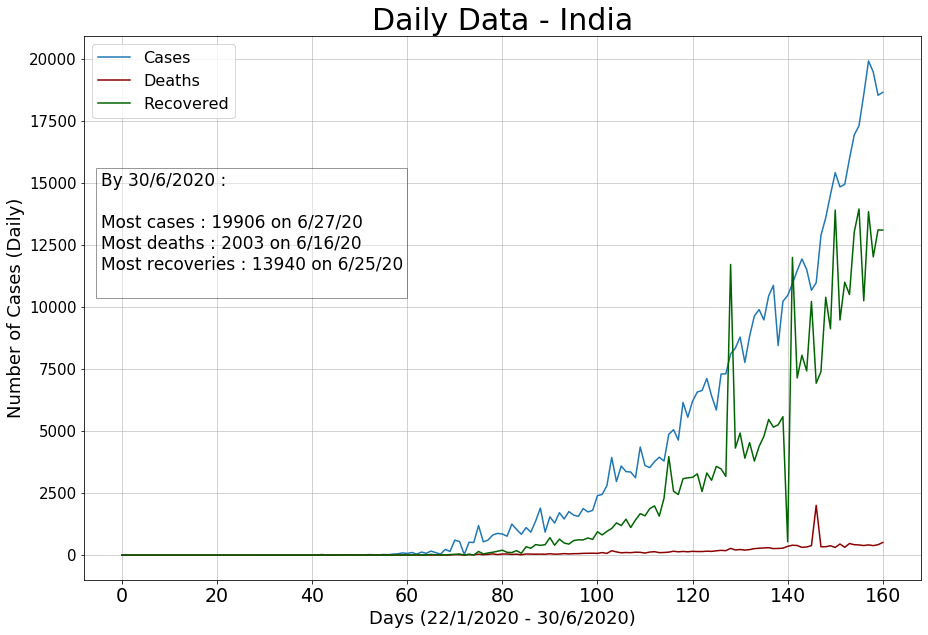

In [196]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title("Daily Data - India", size=30)
   
dates = np.arange(cases.shape[1])

plt.plot(dates, cases_daily.loc['India'], label="Cases")
plt.plot(dates, deaths_daily.loc['India'], label="Deaths", color="darkred")
plt.plot(dates, recovered_daily.loc['India'], label="Recovered", color="darkgreen")


plt.xticks(fontsize=19)
plt.yticks(fontsize=15)
plt.xlabel("Days (22/1/2020 - 30/6/2020)", fontsize=18)
plt.ylabel("Number of Cases (Daily)", fontsize=18)

text = "By 30/6/2020 : \n\n"
text += "Most cases : " + str(cases_daily.loc['India'].max()) + " on " + str(cases_daily.keys().tolist()[cases_daily.loc['India'].argmax()]) + "\n"
text += "Most deaths : " + str(deaths_daily.loc['India'].max()) + " on " + str(deaths_daily.keys().tolist()[deaths_daily.loc['India'].argmax()]) + "\n"
text += "Most recoveries : " + str(recovered_daily.loc['India'].max()) + " on " + str(recovered_daily.keys().tolist()[recovered_daily.loc['India'].argmax()]) + "\n"
plt.text(0.02, 0.75, text, fontsize = 17, horizontalalignment='left', verticalalignment='top',
         transform= ax.transAxes, bbox=dict(facecolor='white', alpha=0.4))

plt.grid(alpha=0.7)
plt.legend(loc='best', fontsize=16)

#     plt.savefig("top5daily_" + str(i) + ".png", bbox_inches='tight')

plt.show()

### Statewise data

In [197]:
df_states_latest = df_states[df_states['date'] == '2020-06-30'].reset_index().drop('index', axis=1) 
df_states_latest.drop(index=9, inplace=True)
df_states_latest['mortality rate'] = np.round(100 * (df_states_latest['deaths'] / df_states_latest['confirmed']), 2)
df_states_latest['recovery rate'] = np.round(100 * (df_states_latest['recovered'] / df_states_latest['confirmed']), 2)
df_states_latest['percent active'] = np.round(100 * (df_states_latest['active'] / df_states_latest['confirmed']), 2)
df_states_latest.style.background_gradient(subset = ['confirmed','recovered','deaths','active'])\
                      .background_gradient(cmap = 'Reds', subset = ['mortality rate'])\
                      .background_gradient(cmap='Greens',subset=['recovery rate'])\
                      .background_gradient(cmap='Oranges', subset=['percent active'])


In [198]:
fp = "india-map/Indian_States.shp" # contains geometric data about the map of india
map_df = gdp.read_file(fp)
# To make the names consistent in both dataframes
map_df['st_nm'][0] = 'Andaman and Nicobar Islands'
map_df['st_nm'][1] = 'Arunachal Pradesh'
map_df['st_nm'][12] = 'Jammu and Kashmir'
map_df['st_nm'][23] = 'Delhi'

In [199]:
merged = map_df.set_index('st_nm').join(df_states_latest.set_index('state'))
#Redundant columns
merged.loc['Dadara & Nagar Havelli', 'confirmed'] = df_states_latest.set_index('state').loc['Dadra and Nagar Haveli and Daman and Diu', 'confirmed']
merged.loc['Daman & Diu', 'confirmed'] = df_states_latest.set_index('state').loc['Dadra and Nagar Haveli and Daman and Diu', 'confirmed']
merged.head()

geometry  \
st_nm                                                                            
Andaman and Nicobar Islands  MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...   
Arunachal Pradesh            POLYGON ((96.16261 29.38078, 96.16860 29.37432...   
Assam                        MULTIPOLYGON (((89.74323 26.30362, 89.74290 26...   
Bihar                        MULTIPOLYGON (((84.50720 24.26323, 84.50355 24...   
Chandigarh                   POLYGON ((76.84147 30.75996, 76.83599 30.73623...   

                             confirmed  recovered  deaths  active        date  \
st_nm                                                                           
Andaman and Nicobar Islands       97.0       45.0     0.0    52.0  2020-06-30   
Arunachal Pradesh                191.0       62.0     1.0   128.0  2020-06-30   
Assam                           8408.0     5648.0    12.0  2745.0  2020-06-30   
Bihar                           9988.0     7544.0    68.0  2376.0  2020-06-30   
Chandigarh                       440.0      364.0     6.0    70.0  2020-06-30   

                             mortality rate  recovery rate  percent active  
st_nm                                                                       
Andaman and Nicobar Islands            0.00          46.39           53.61  
Arunachal Pradesh                      0.52          32.46           67.02  
Assam                                  0.14          67.17           32.65  
Bihar                                  0.68          75.53           23.79  
Chandigarh                             1.36          82.73           15.91

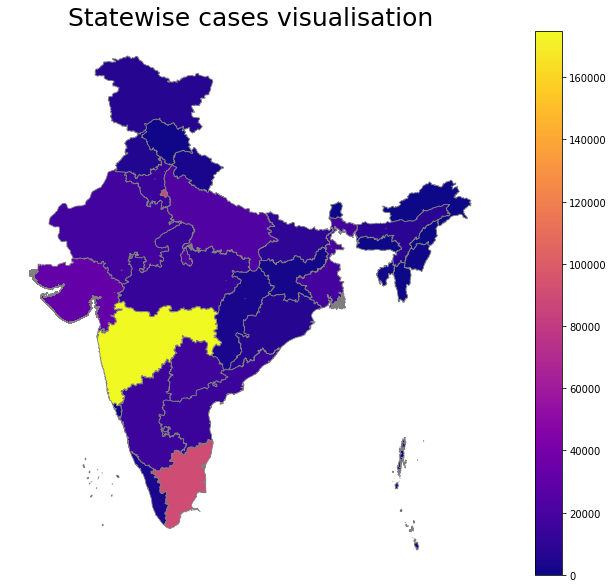

In [200]:
fig, ax = plt.subplots(figsize=(15,10))
ax.axis('off')
plt.title('Statewise cases visualisation', fontsize=25)
merged.plot(column='confirmed', cmap='plasma', linewidth=0.8,edgecolor='0.5', ax=ax, legend=True)
# plt.legend()
# plt.savefig('india-map-cases.png', bbox_inches='tight')
plt.show()

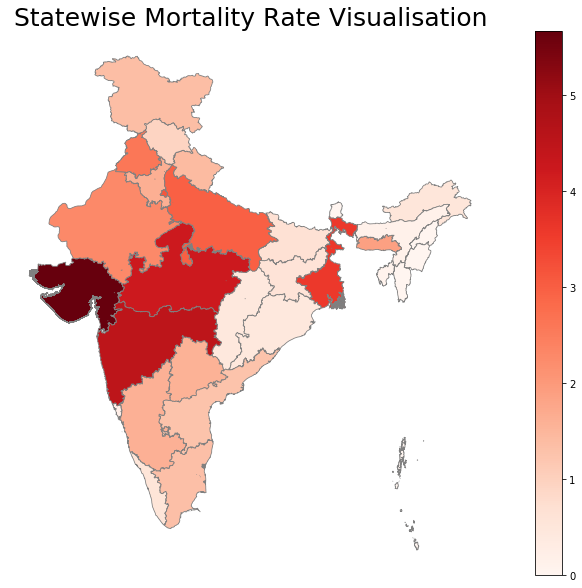

In [201]:
fig, ax = plt.subplots(figsize=(15,10))
ax.axis('off')
plt.title('Statewise Mortality Rate Visualisation', fontsize=25)
merged.plot(column='mortality rate', cmap='Reds', linewidth=0.8,edgecolor='0.5', ax=ax, legend=True)
# plt.legend()
# plt.savefig('india-map-death.png', bbox_inches='tight')
plt.show()

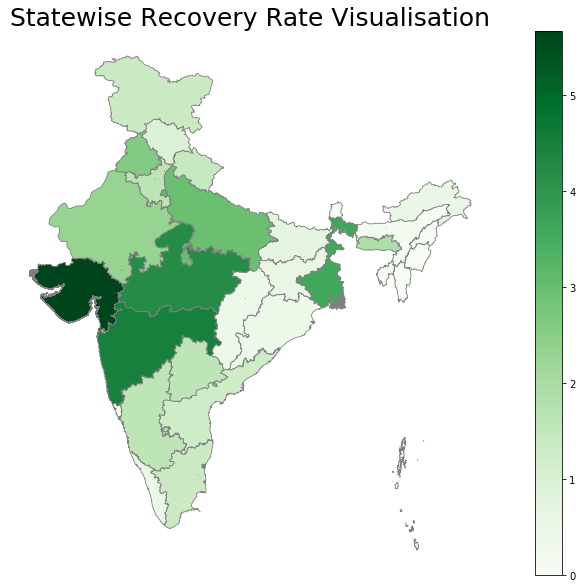

In [202]:
fig, ax = plt.subplots(figsize=(15,10))
ax.axis('off')
plt.title('Statewise Recovery Rate Visualisation', fontsize=25)
merged.plot(column='mortality rate', cmap='Greens', linewidth=0.8,edgecolor='0.5', ax=ax, legend=True)
# plt.legend()
# plt.savefig('india-map-recovered.png', bbox_inches='tight')
plt.show()

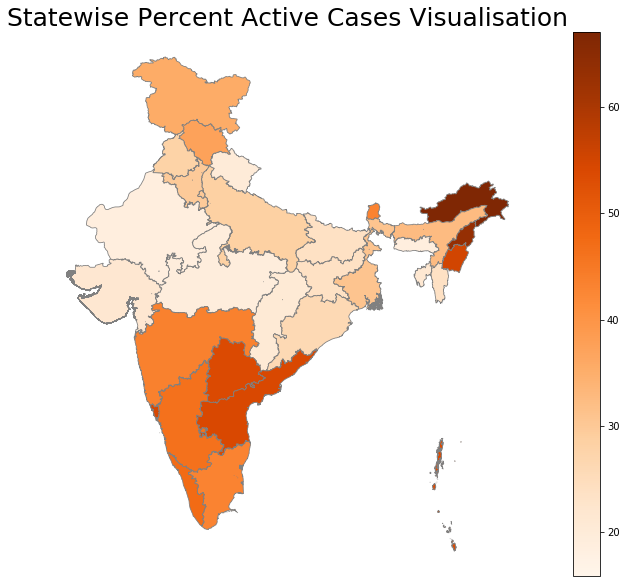

In [203]:
fig, ax = plt.subplots(figsize=(15,10))
ax.axis('off')
plt.title('Statewise Percent Active Cases Visualisation', fontsize=25)
merged.plot(column='percent active', cmap='Oranges', linewidth=0.8,edgecolor='0.5', ax=ax, legend=True)
# plt.savefig('india-map-active.png', bbox_inches='tight')
# plt.legend()
plt.show()

In [204]:
df_states = df_states.set_index('state')

In [205]:
# Removing redundant entries
df_states.drop(['Daman and Diu', 'Dadra and Nagar Haveli', 'Dadra and Nagar Haveli and Daman and Diu', 'State Unassigned'], axis = 0, inplace=True)


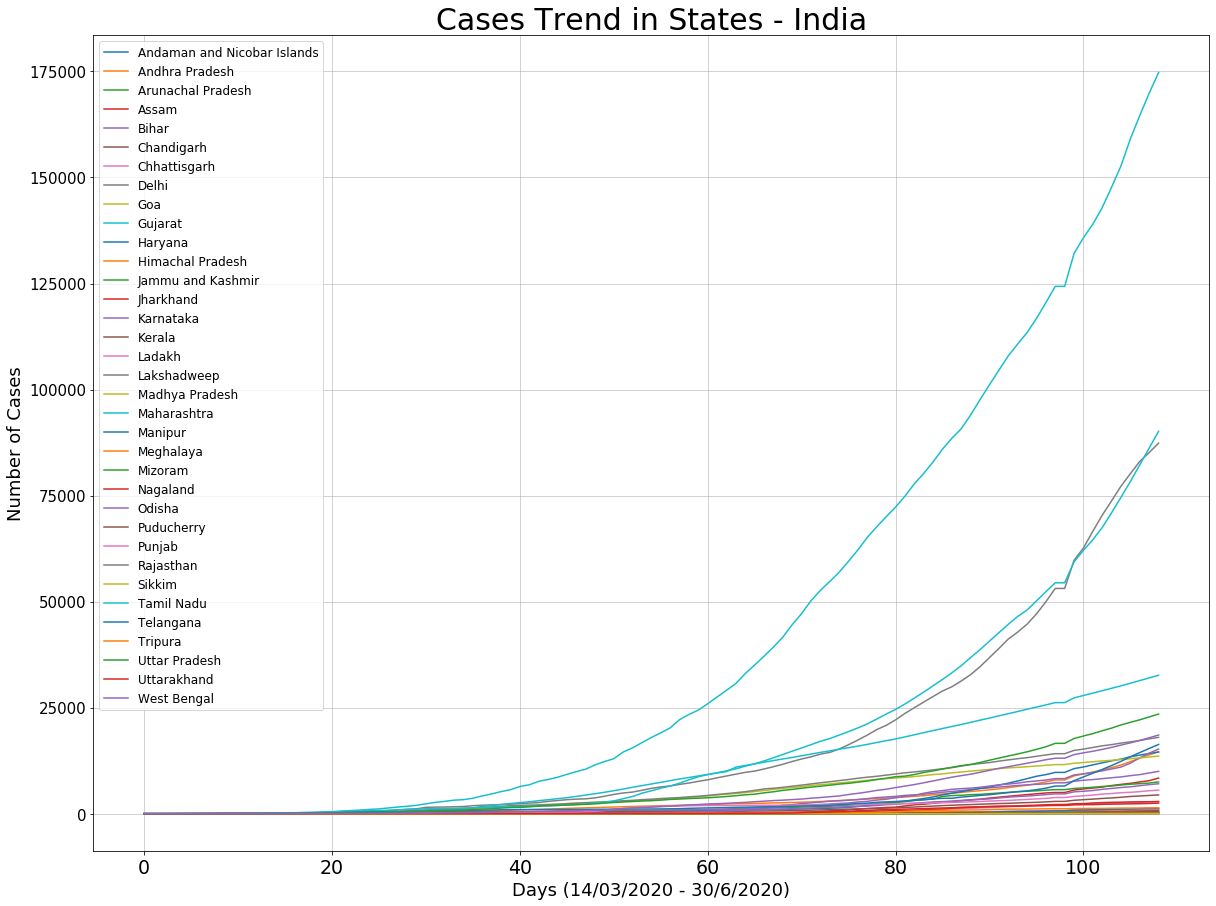

In [206]:
fig, ax = plt.subplots(figsize=(20,15))
plt.title("Cases Trend in States - India", size=30)

days = np.arange(df_states.loc['Delhi'].shape[0])

for state in np.unique(np.array(df_states.index)):
    if df_states.loc[state].shape[0] < 109:
        print(state)
    plt.plot(days, df_states.loc[state, 'confirmed'], label=state)

plt.xticks(fontsize=19)
plt.yticks(fontsize=15)
plt.xlabel("Days (14/03/2020 - 30/6/2020)", fontsize=18)
plt.ylabel("Number of Cases", fontsize=18)

plt.grid(alpha=0.7)
plt.legend(loc='best', fontsize=12)

# plt.savefig("india_all.png", bbox_inches='tight')

plt.show()

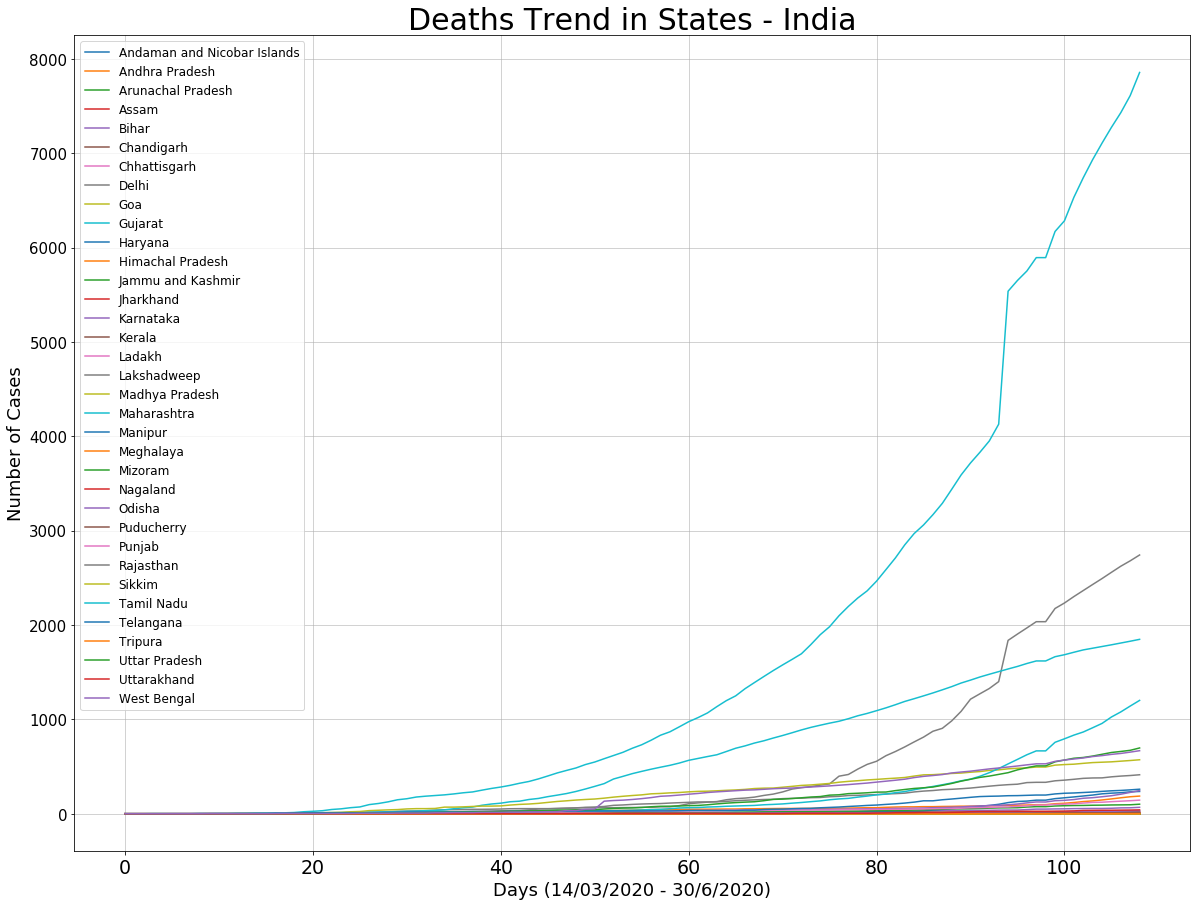

In [207]:
fig, ax = plt.subplots(figsize=(20,15))
plt.title("Deaths Trend in States - India", size=30)

days = np.arange(df_states.loc['Delhi'].shape[0])

for state in np.unique(np.array(df_states.index)):
    if df_states.loc[state].shape[0] < 109:
        print(state)
    plt.plot(days, df_states.loc[state, 'deaths'], label=state)

plt.xticks(fontsize=19)
plt.yticks(fontsize=15)
plt.xlabel("Days (14/03/2020 - 30/6/2020)", fontsize=18)
plt.ylabel("Number of Cases", fontsize=18)

plt.grid(alpha=0.7)
plt.legend(loc='best', fontsize=12)

# plt.savefig("india_all-deaths.png", bbox_inches='tight')

plt.show()

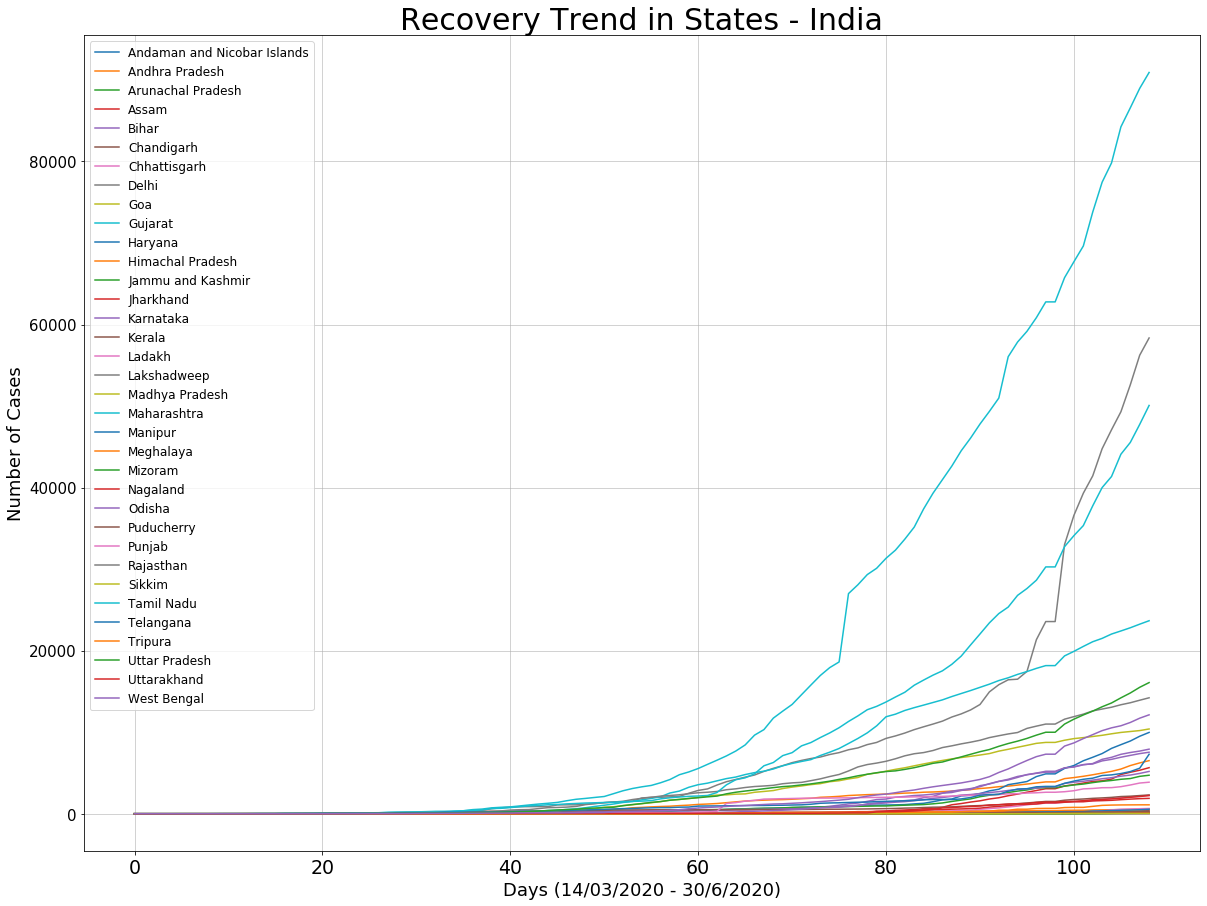

In [208]:
fig, ax = plt.subplots(figsize=(20,15))
plt.title("Recovery Trend in States - India", size=30)

days = np.arange(df_states.loc['Delhi'].shape[0])

for state in np.unique(np.array(df_states.index)):
    if df_states.loc[state].shape[0] < 109:
        print(state)
    plt.plot(days, df_states.loc[state, 'recovered'], label=state)

plt.xticks(fontsize=19)
plt.yticks(fontsize=15)
plt.xlabel("Days (14/03/2020 - 30/6/2020)", fontsize=18)
plt.ylabel("Number of Cases", fontsize=18)

plt.grid(alpha=0.7)
plt.legend(loc='best', fontsize=12)

# plt.savefig("india_all_recovery.png", bbox_inches='tight')

plt.show()

In [209]:
df_states_latest = df_states_latest.set_index('state')


In [210]:
top5 = df_states_latest.iloc[:5, :]
top5

confirmed  recovered  deaths   active        date  \
state                                                              
Maharashtra     174761.0    90911.0  7855.0  75979.0  2020-06-30   
Tamil Nadu       90167.0    50074.0  1201.0  38892.0  2020-06-30   
Delhi            87360.0    58348.0  2742.0  26270.0  2020-06-30   
Gujarat          32643.0    23670.0  1848.0   7125.0  2020-06-30   
Uttar Pradesh    23492.0    16084.0   697.0   6711.0  2020-06-30   

               mortality rate  recovery rate  percent active  
state                                                         
Maharashtra              4.49          52.02           43.48  
Tamil Nadu               1.33          55.53           43.13  
Delhi                    3.14          66.79           30.07  
Gujarat                  5.66          72.51           21.83  
Uttar Pradesh            2.97          68.47           28.57

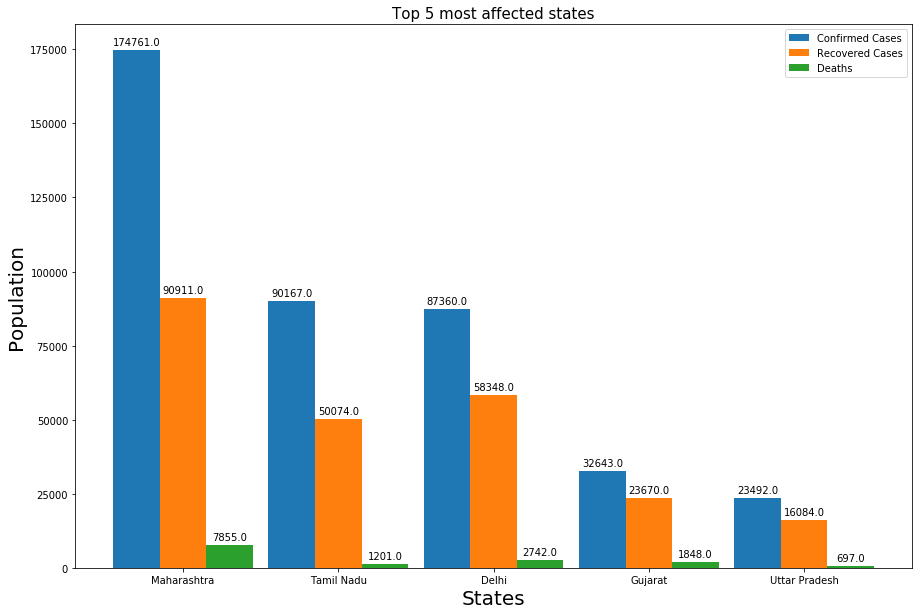

In [211]:
top5 = df_states_latest.iloc[:5, :]
labels = top5.index.tolist()
confirmed = top5['confirmed'].values
deaths = top5['deaths'].values
recovered = top5['recovered'].values

x = np.arange(len(labels))
width = 0.30

f, ax = plt.subplots()
f.set_size_inches(15, 10)
bar1 = plt.bar(x - width, confirmed, width, label='Confirmed Cases')
bar2 = plt.bar(x, recovered, width, label='Recovered Cases')
bar3 = plt.bar(x + width, deaths, width, label='Deaths')

ax.ticklabel_format(style='plain')
plt.xticks(x, (labels))
plt.xlabel('States', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.title('Top 5 most affected states', fontsize=15)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.legend()
# plt.savefig('india-top5-latest.png', bbox_inches='tight')
plt.show()

In [212]:
top5_series = df_states.loc[top5.index.tolist(), :]
states = np.unique(np.array(top5_series.index))

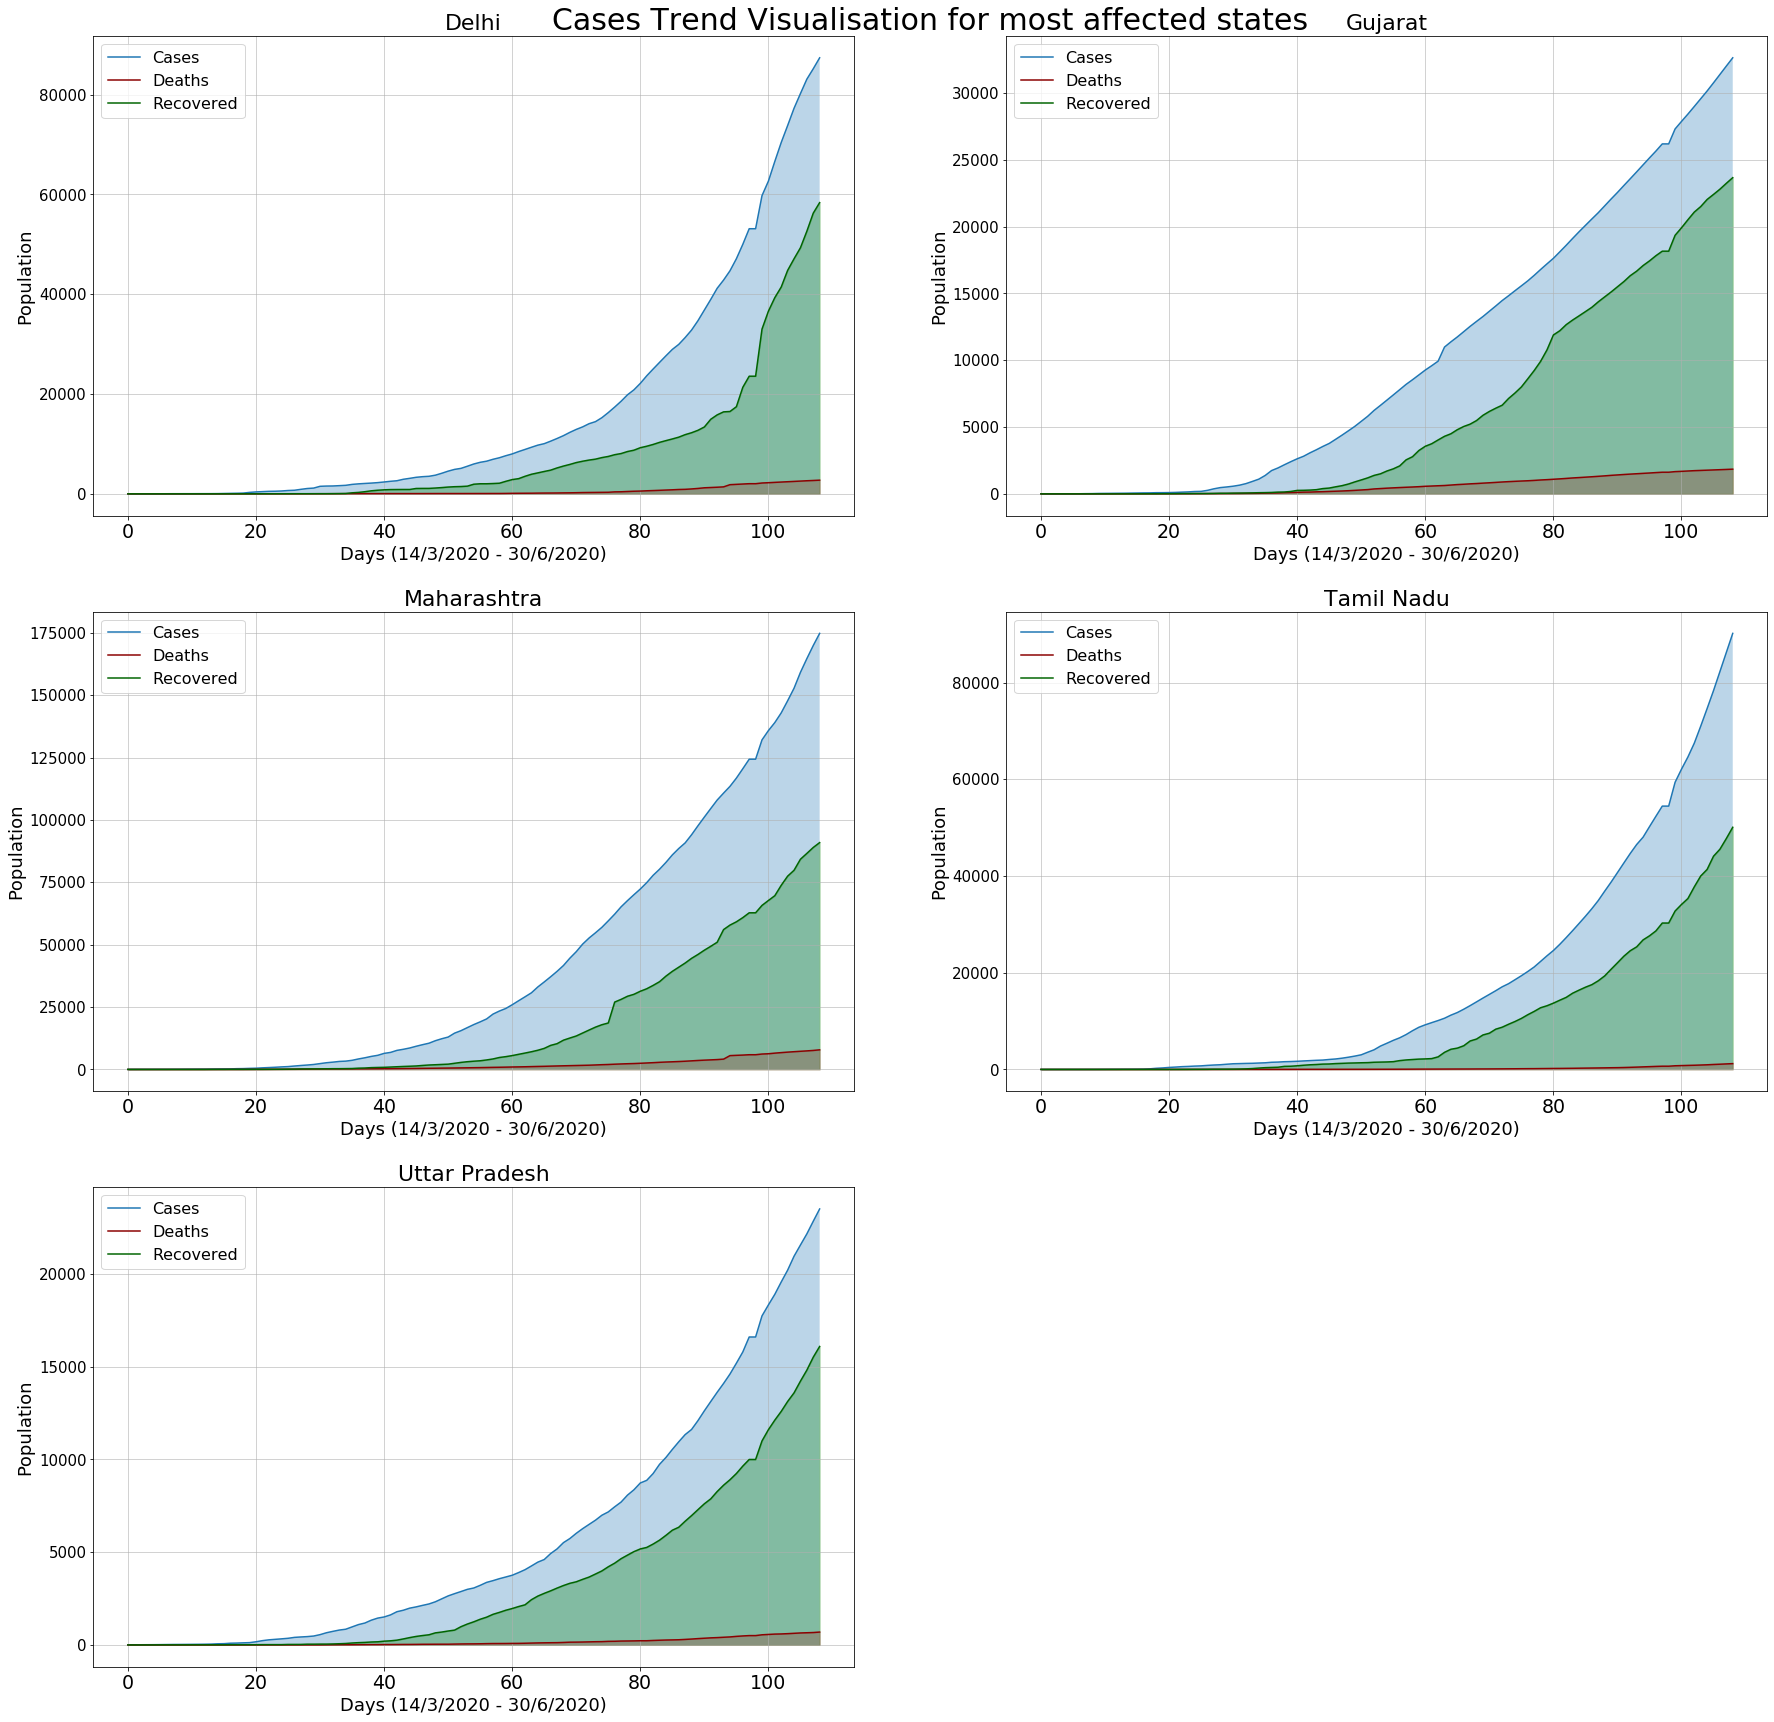

In [213]:
fig, ax = plt.subplots(figsize=(30,30))
plt.title('Cases Trend Visualisation for most affected states', size=30)
ax.axis('off')
cols = 2
rows = int(np.ceil(len(states)/cols))

days = np.arange(df_states.loc['Delhi'].shape[0])

for i, state in enumerate(states):
    ax = fig.add_subplot(rows, cols, i+1)
#     fig, ax = plt.subplots(figsize=(15,10))
    plt.plot(days, top5_series.loc[state, 'confirmed'], label='Cases')
    plt.plot(days, top5_series.loc[state, 'deaths'], label='Deaths', color='darkred')
    plt.plot(days, top5_series.loc[state, 'recovered'], label='Recovered', color='darkgreen')
    
    plt.fill_between(days, top5_series.loc[state, 'confirmed'], alpha=0.3)
    plt.fill_between(days, top5_series.loc[state, 'deaths'], alpha=0.3, color='crimson')
    plt.fill_between(days, top5_series.loc[state, 'recovered'], alpha=0.3, color='green')
    
    plt.title(state, fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=15)
    plt.xlabel("Days (14/3/2020 - 30/6/2020)", fontsize=18)
    plt.ylabel("Population", fontsize=18)
    
    plt.grid(alpha=0.7)
    plt.legend(loc='best', fontsize=16)
#     plt.savefig('./paper/india-top5-states-trend.png', bbox_inches='tight')

plt.show()
    
    

In [214]:
# Converting cumulative numbers to daily data
df = top5_series.reset_index()
top5_daily = pd.DataFrame(index = df.index, columns = df.keys())
for i, state in enumerate(df.index.tolist()):
    if i == 0 or df.iloc[i, 0] != df.iloc[i-1, 0]:
        top5_daily.iloc[i, :] = df.iloc[i, :]
    else:
        top5_daily.iloc[i, :-2] = df.iloc[i,1:-2] - df.iloc[i-1, 1:-2]
        top5_daily['date'] = df['date']
        top5_daily['active'] = df['active']
        top5_daily['state'] = df['state']

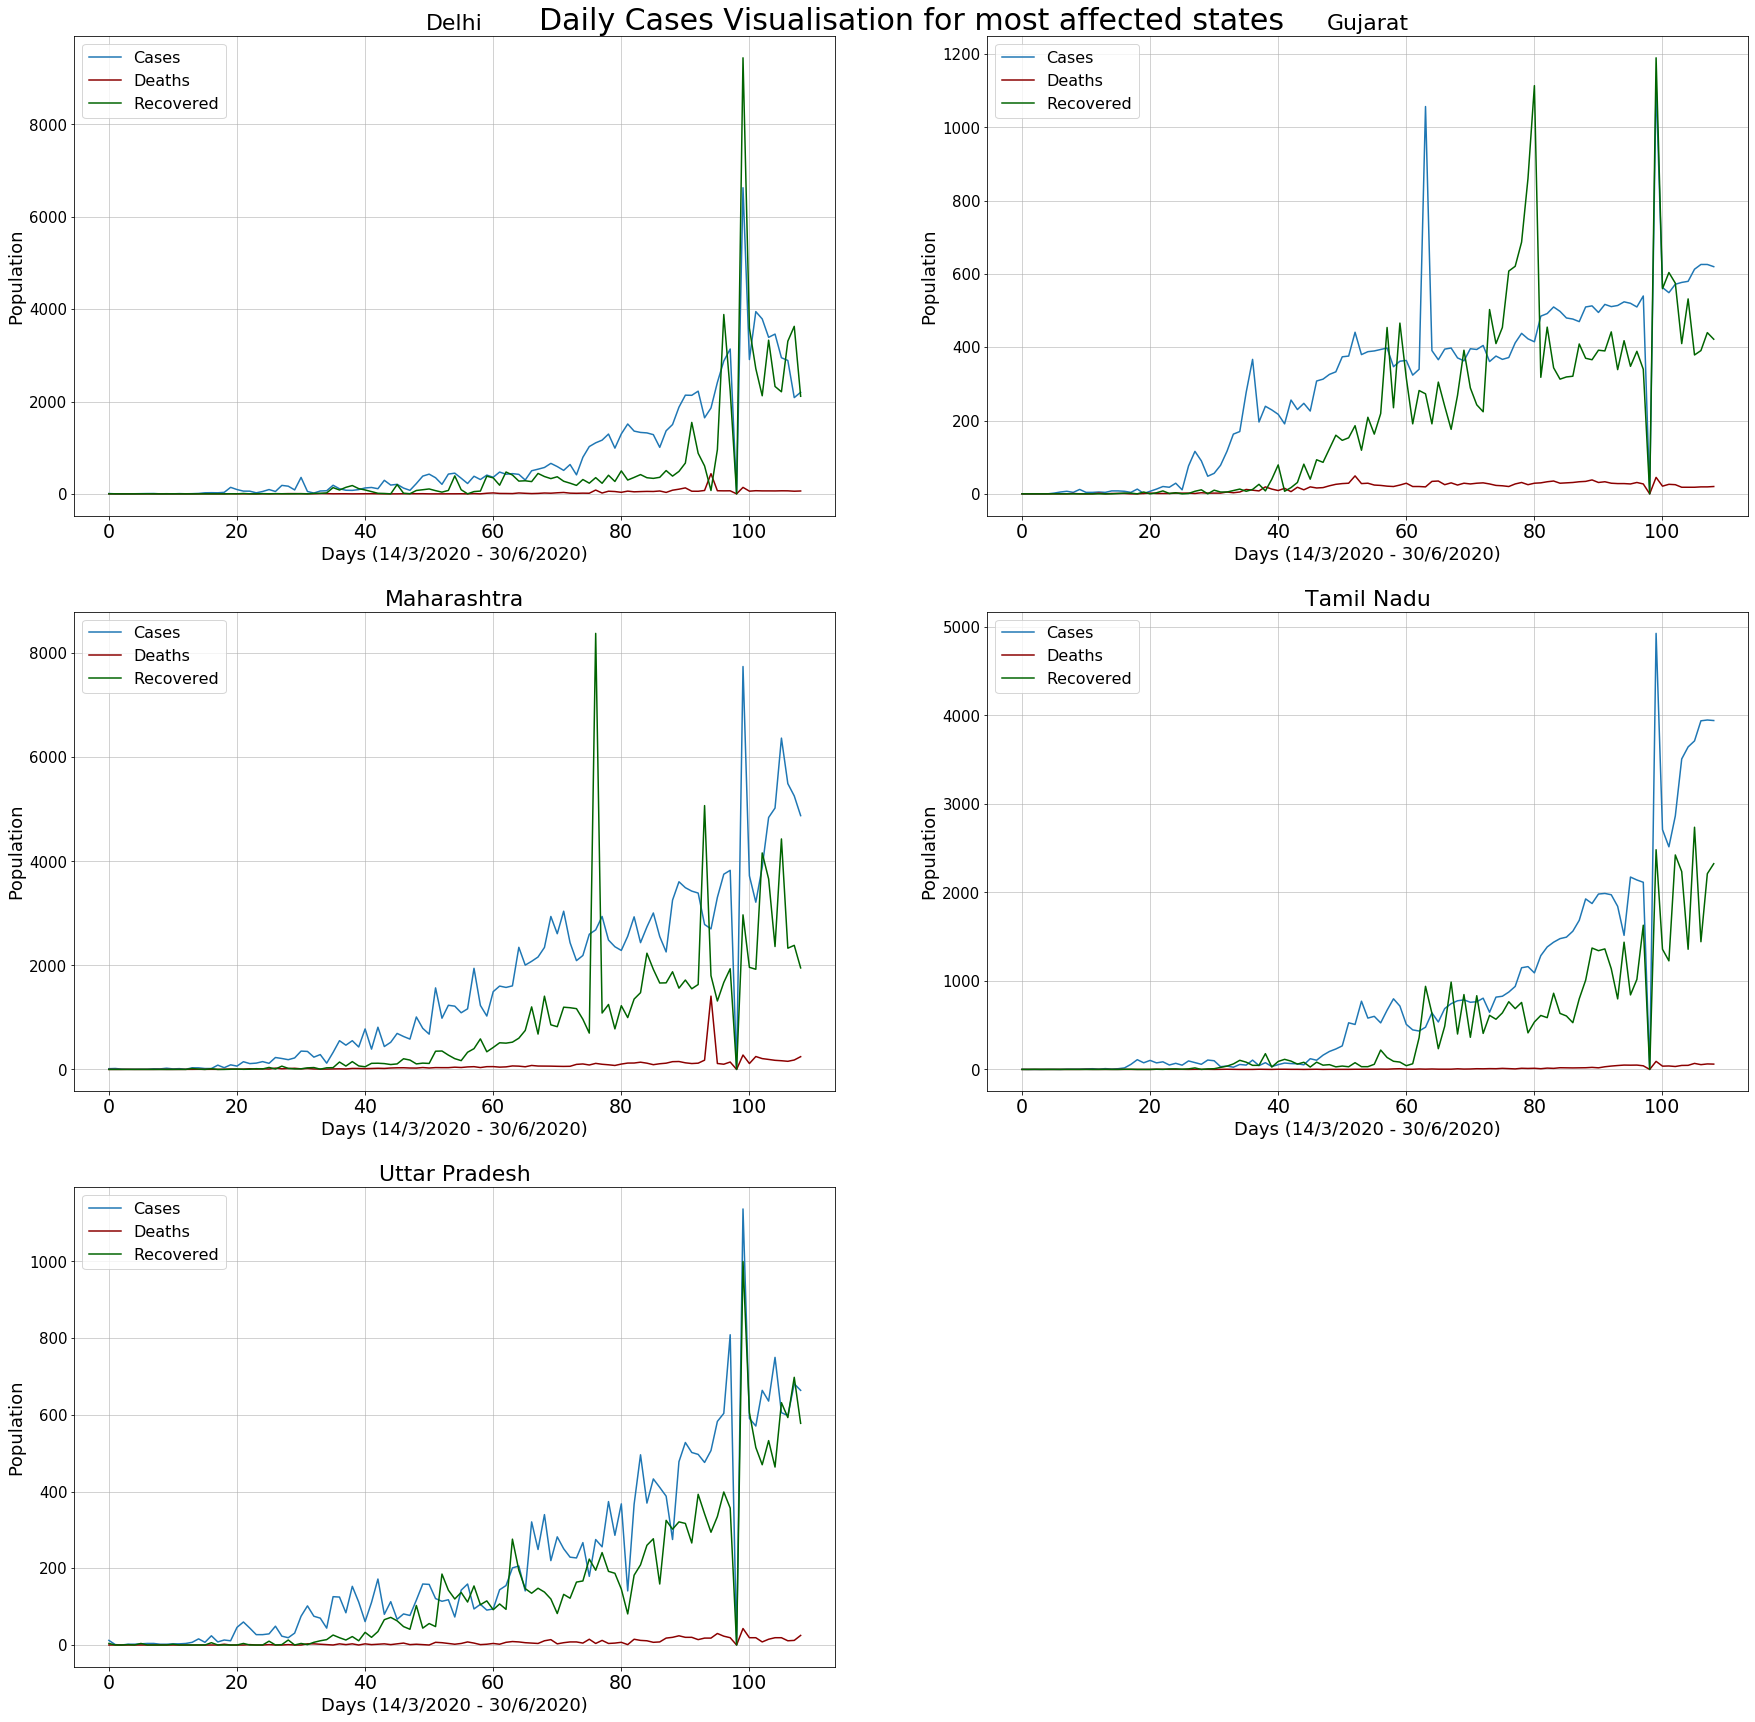

In [215]:
top5_daily = top5_daily.set_index('state')
fig, ax = plt.subplots(figsize=(30,30))
plt.title('Daily Cases Visualisation for most affected states', size=30)
ax.axis('off')
cols = 2
rows = int(np.ceil(len(states)/cols))

days = np.arange(top5_daily.loc['Delhi'].shape[0])

for i, state in enumerate(states):
    ax = fig.add_subplot(rows, cols, i+1)
#     fig, ax = plt.subplots(figsize=(15,10))
    plt.plot(days, top5_daily.loc[state, 'confirmed'], label='Cases')
    plt.plot(days, top5_daily.loc[state, 'deaths'], label='Deaths', color='darkred')
    plt.plot(days, top5_daily.loc[state, 'recovered'], label='Recovered', color='darkgreen')
    
    plt.title(state, fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=15)
    plt.xlabel("Days (14/3/2020 - 30/6/2020)", fontsize=18)
    plt.ylabel("Population", fontsize=18)
    
    plt.grid(alpha=0.7)
    plt.legend(loc='best', fontsize=16)
    
    plt.savefig('./paper/india-top5-states-daily.png', bbox_inches='tight')

plt.show()
    
    

In [216]:
bottom5 = df_states_latest.sort_values('confirmed').iloc[:5, :]
bottom5.fillna(0, inplace=True)

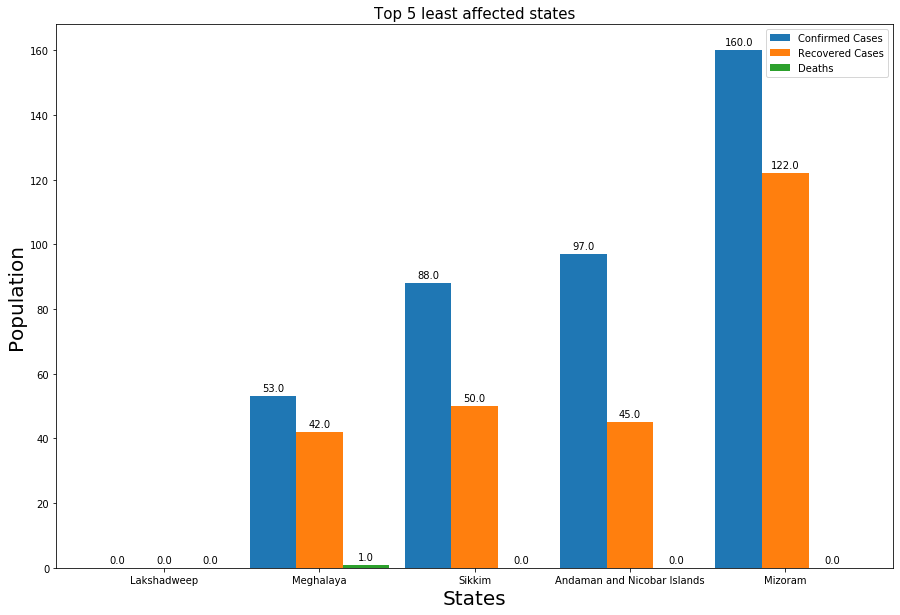

In [217]:
labels = bottom5.index.tolist()
confirmed = bottom5['confirmed'].values
deaths = bottom5['deaths'].values
recovered = bottom5['recovered'].values

x = np.arange(len(labels))
width = 0.30

f, ax = plt.subplots()
f.set_size_inches(15, 10)
bar1 = plt.bar(x - width, confirmed, width, label='Confirmed Cases')
bar2 = plt.bar(x, recovered, width, label='Recovered Cases')
bar3 = plt.bar(x + width, deaths, width, label='Deaths')

ax.ticklabel_format(style='plain')
plt.xticks(x, (labels))
plt.xlabel('States', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.title('Top 5 least affected states', fontsize=15)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.legend()
plt.savefig('./paper/india-bottom-5.png', bbox_inches='tight')
plt.show()

In [218]:
bottom5_series = df_states.loc[bottom5.index.tolist()]
states = np.unique(np.array(bottom5_series.index))

In [219]:
# Correcting the faulty data; Total cases in Lakshadweep were 0 as of 30 June 2020.
bottom5_series[bottom5_series.index == 'Lakshadweep'] = 0

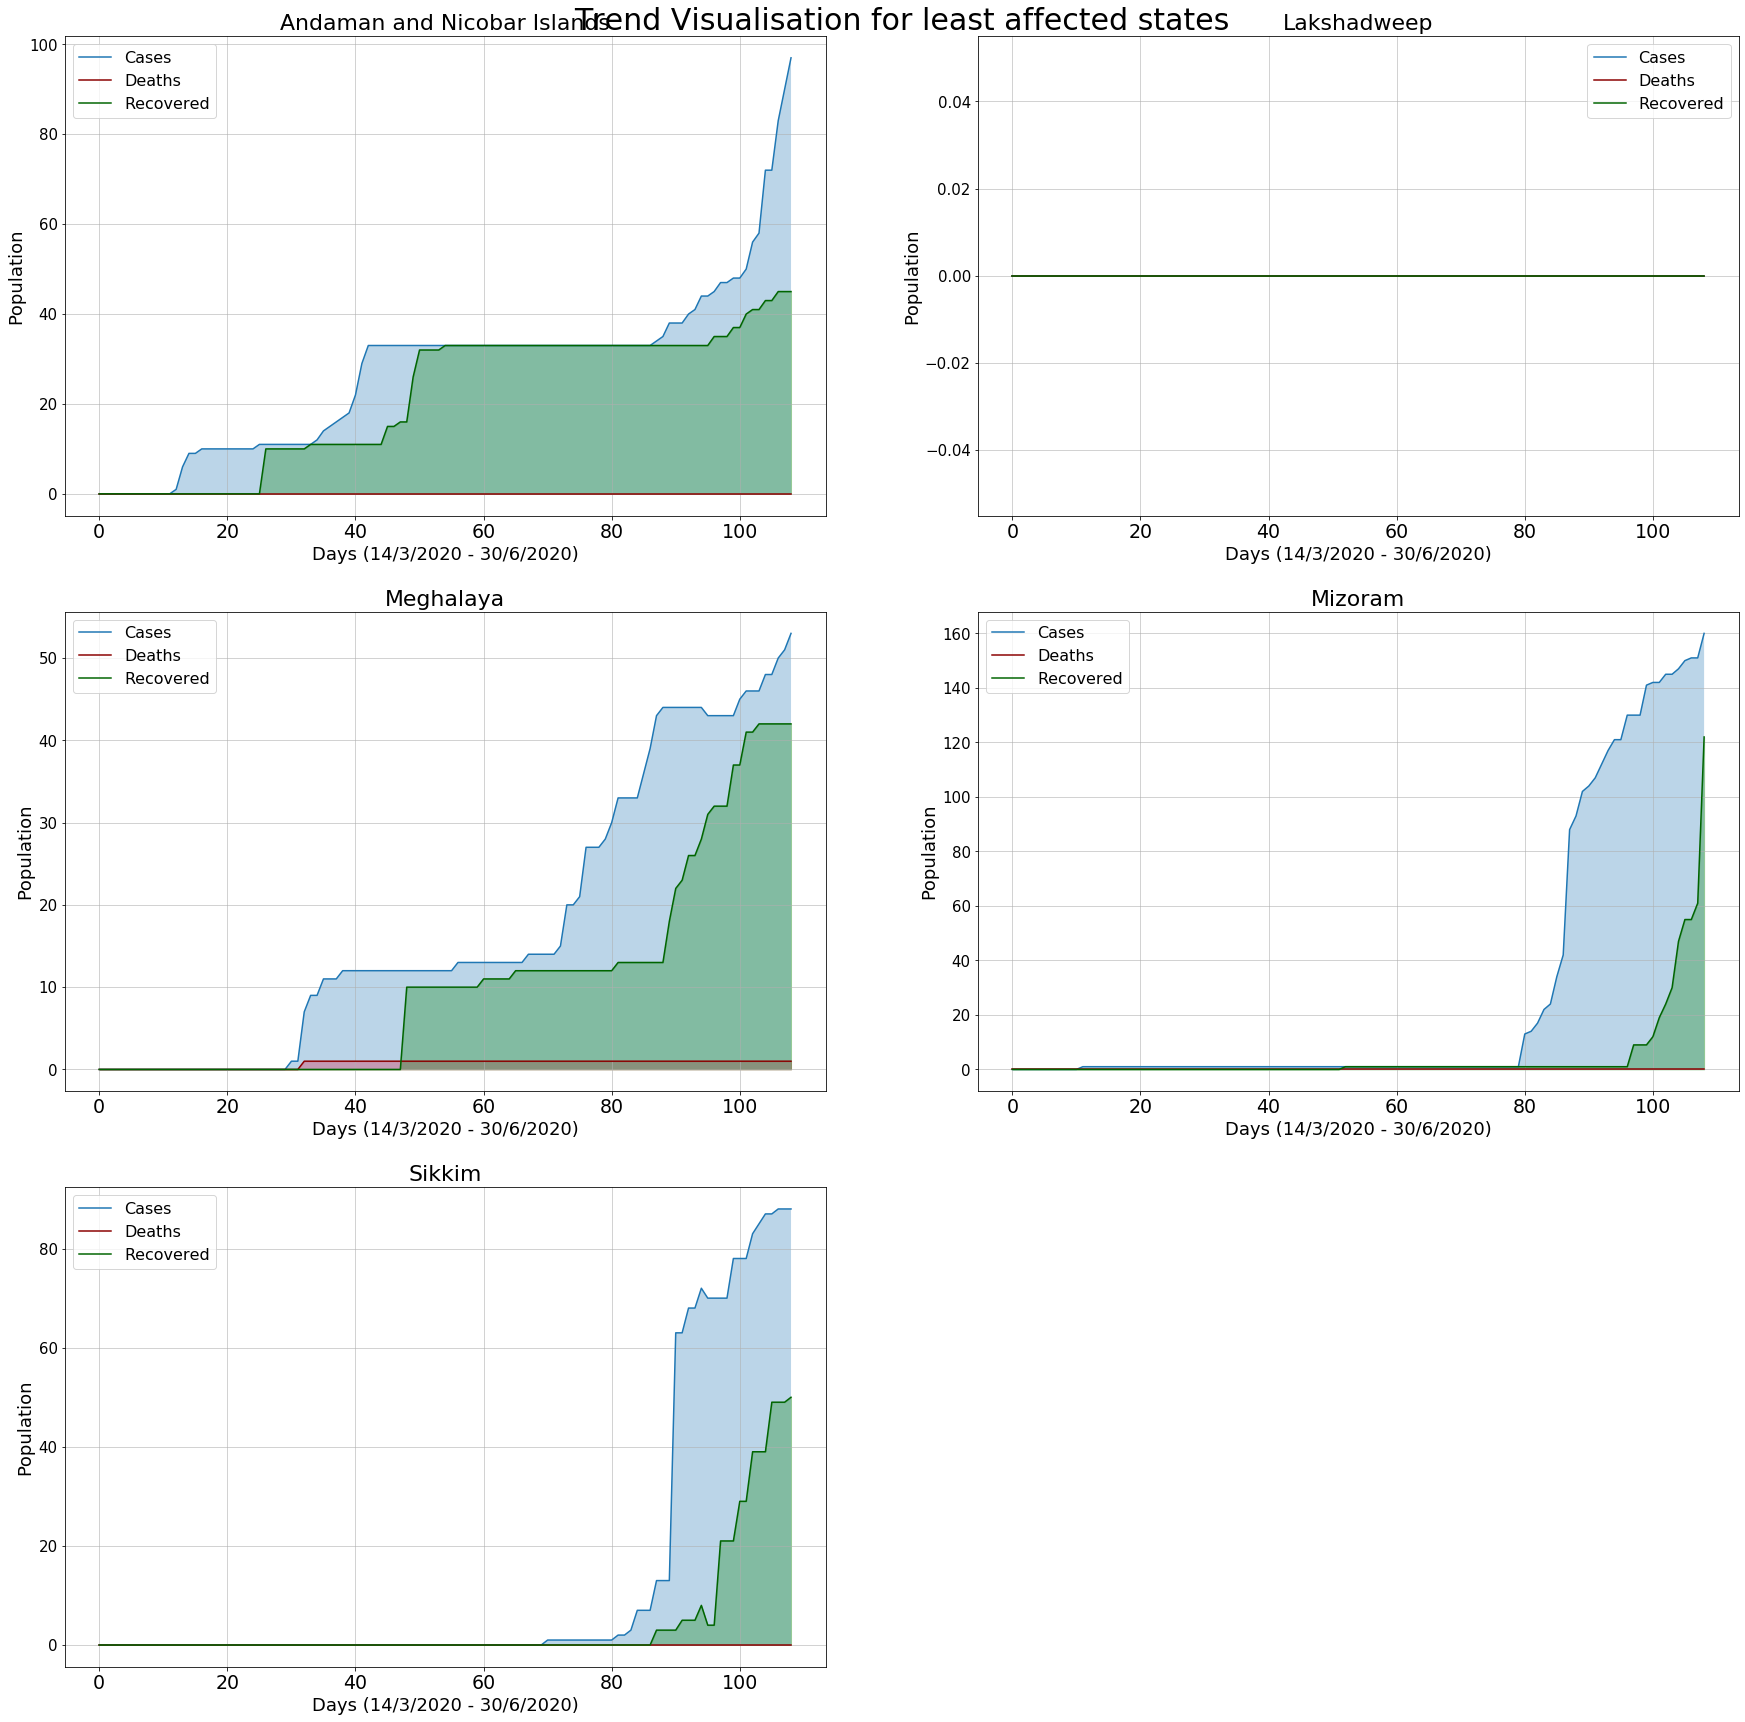

In [220]:
fig, ax = plt.subplots(figsize=(30,30))
plt.title('Trend Visualisation for least affected states', size=30)
ax.axis('off')
cols = 2
rows = int(np.ceil(len(states)/cols))

days = np.arange(df_states.loc['Delhi'].shape[0])

for i, state in enumerate(states):
    ax = fig.add_subplot(rows, cols, i+1)
#     fig, ax = plt.subplots(figsize=(15,10))
    plt.plot(days, bottom5_series.loc[state, 'confirmed'], label='Cases')
    plt.plot(days, bottom5_series.loc[state, 'deaths'], label='Deaths', color='darkred')
    plt.plot(days, bottom5_series.loc[state, 'recovered'], label='Recovered', color='darkgreen')
    
    plt.fill_between(days, bottom5_series.loc[state, 'confirmed'], alpha=0.3)
    plt.fill_between(days, bottom5_series.loc[state, 'deaths'], alpha=0.3, color='crimson')
    plt.fill_between(days, bottom5_series.loc[state, 'recovered'], alpha=0.3, color='green')
    
    plt.title(state, fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=15)
    plt.xlabel("Days (14/3/2020 - 30/6/2020)", fontsize=18)
    plt.ylabel("Population", fontsize=18)
    
    plt.grid(alpha=0.7)
    plt.legend(loc='best', fontsize=16)
    
#     plt.savefig('./paper/india-bottom5-trend.png', bbox_inches='tight')

plt.show()
    
    

In [221]:
df = bottom5_series.reset_index()
bottom5_daily = pd.DataFrame(index = df.index, columns = df.keys())
for i, state in enumerate(df.index.tolist()):
    if i == 0 or df.iloc[i, 0] != df.iloc[i-1, 0]:
        bottom5_daily.iloc[i, :] = df.iloc[i, :]
    else:
        bottom5_daily.iloc[i, :-2] = df.iloc[i,1:-2] - df.iloc[i-1, 1:-2]
        bottom5_daily['date'] = df['date']
        bottom5_daily['active'] = df['active']
        bottom5_daily['state'] = df['state']


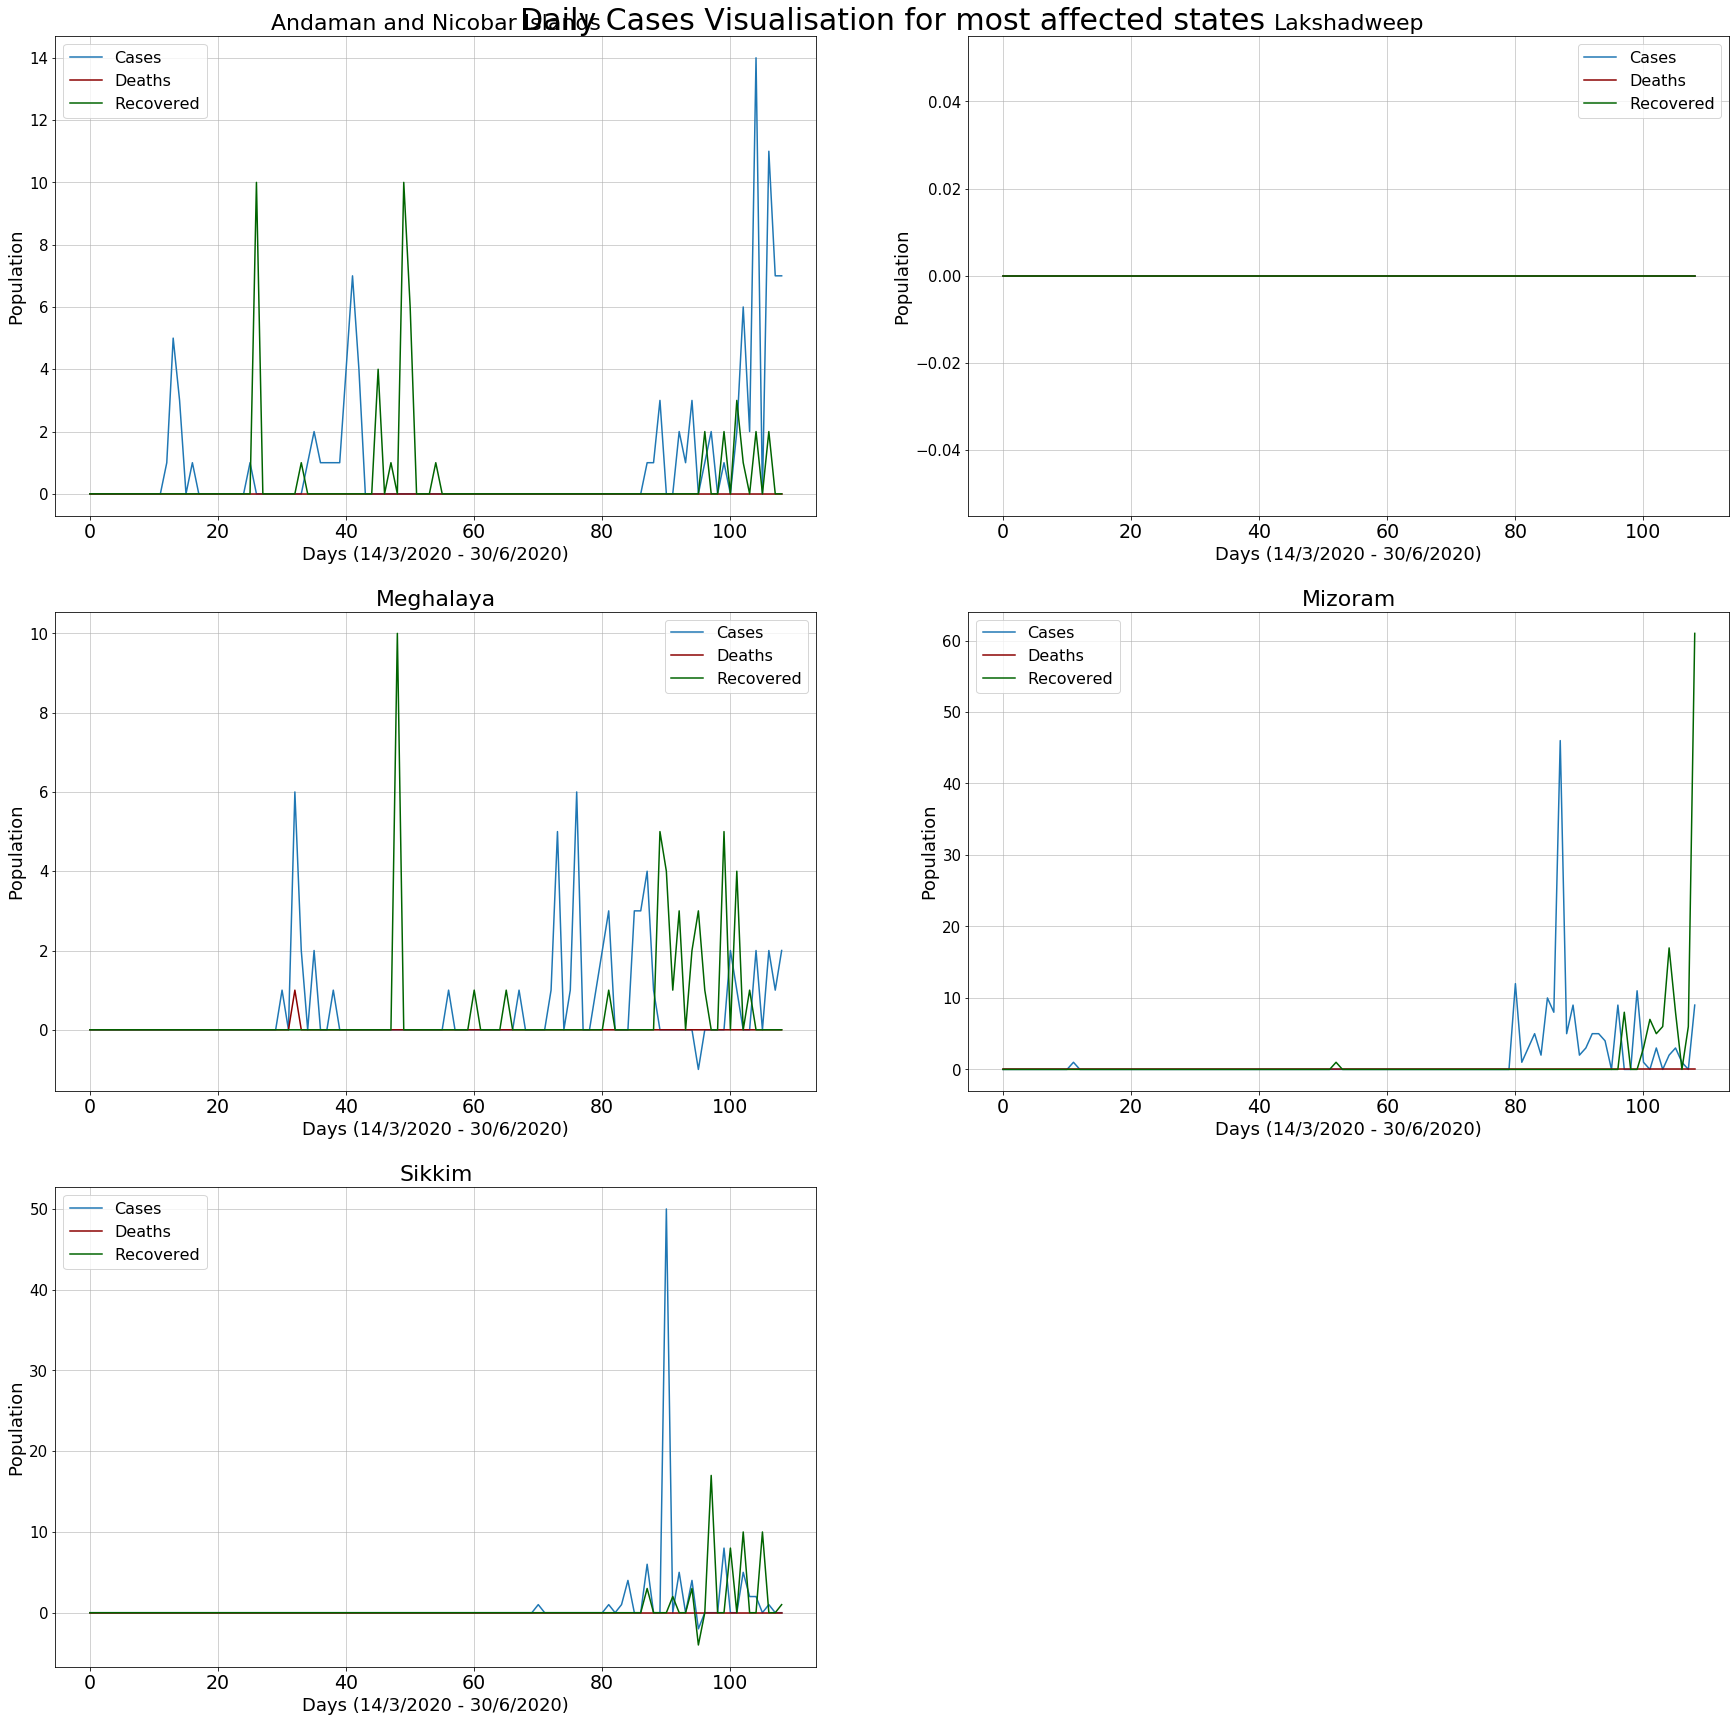

In [222]:
bottom5_daily = bottom5_daily.set_index('state')
fig, ax = plt.subplots(figsize=(30,30))
plt.title('Daily Cases Visualisation for most affected states', size=30)
ax.axis('off')
cols = 2
rows = int(np.ceil(len(states)/cols))

days = np.arange(top5_daily.loc['Delhi'].shape[0])

for i, state in enumerate(states):
    ax = fig.add_subplot(rows, cols, i+1)
    
#     fig, ax = plt.subplots(figsize=(15,10))
    
    plt.plot(days, bottom5_daily.loc[state, 'confirmed'], label='Cases')
    plt.plot(days, bottom5_daily.loc[state, 'deaths'], label='Deaths', color='darkred')
    plt.plot(days, bottom5_daily.loc[state, 'recovered'], label='Recovered', color='darkgreen')
    
    plt.title(state, fontsize=22)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=15)
    plt.xlabel("Days (14/3/2020 - 30/6/2020)", fontsize=18)
    plt.ylabel("Population", fontsize=18)
    
    plt.grid(alpha=0.7)
    plt.legend(loc='best', fontsize=16)
    
#     plt.savefig('./paper/india-bottom5-daily.png', bbox_inches = 'tight')

plt.show()

## Testing in India

In [223]:
df_india_test = pd.io.json.json_normalize(requests.get('https://api.rootnet.in/covid19-in/stats/testing/history')\
                                          .json()['data']).rename(columns =\
                                            {"totalIndividualsTested":"c_individualtest",\
                                             "totalPositiveCases":"c_positive",\
                                            "totalSamplesTested":"c_tests"})

In [224]:
df_india_test["p2t_ratio"]= np.round(100*df_india_test["c_positive"]/df_india_test["c_tests"],2)
df_india_test["positive"] = df_india_test["c_positive"].diff()
df_india_test["tests"] = df_india_test["c_tests"].diff()
df_india_test["p2t_ratio"]= np.round(100*df_india_test["positive"]/df_india_test["tests"],2)
df_india_test = df_india_test[1:]

In [225]:
df_india_test = df_india_test[df_india_test['day'] <= '2020-06-30']

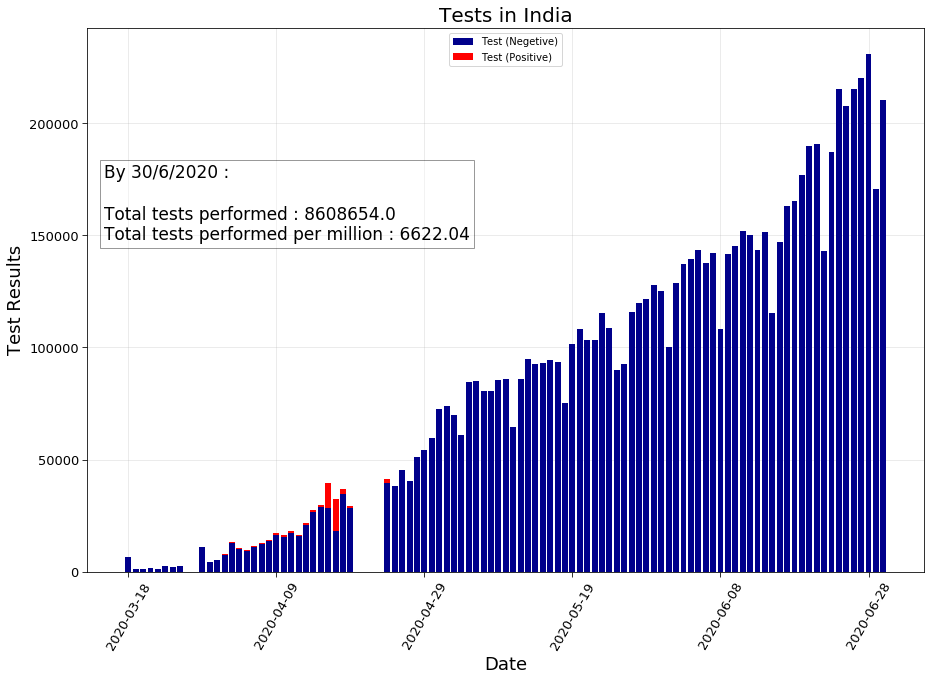

In [226]:
fig, ax = plt.subplots(figsize=(15,10))

plt.axes(axisbelow=True)
plt.bar(df_india_test["day"],df_india_test["tests"].values[:],color="darkblue",label="Test (Negetive)"+str())
plt.bar(df_india_test["day"],df_india_test["positive"].values[:],bottom=df_india_test["tests"].values[:]-df_india_test["positive"].values[:],color="Red",label="Test (Positive)")
plt.tick_params(size=5,labelsize = 13)
plt.tick_params(axis="x",size=5,labelsize = 13,labelrotation=60 )
plt.xlabel("Date",fontsize=18)
plt.ylabel("Test Results",fontsize=18)

# X-axis
date = df_india_test["day"].values
plt.xticks(list(np.arange(0,len(date),int(len(date)/5))),date[:-1:int(len(date)/5)])

text = "By 30/6/2020 : \n\n"
text += "Total tests performed : " + str(df_india_test["c_tests"][-1:].values[0]) + "\n"
text += "Total tests performed per million : " + str(np.round(1000000*df_india_test["c_tests"][-1:].values[0]/1300000000,2)) 
plt.text(0.02, 0.75, text, fontsize = 17, horizontalalignment='left', verticalalignment='top',
         transform= ax.transAxes, bbox=dict(facecolor='white', alpha=0.4))

plt.title("Tests in India",fontsize=20)
plt.grid(alpha=0.3)
plt.legend()
# plt.savefig('Test_India.png', bbox_inches='tight')
plt.show()

In [227]:
testing_data = requests.get('https://api.covid19india.org/state_test_data.json').json()
testing_states = pd.json_normalize(testing_data['states_tested_data'])

In [228]:
testing_states.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [229]:
testing_states

coronaenquirycalls cumulativepeopleinquarantine negative  \
0                   NaN                          NaN     1210   
1                   NaN                          NaN      NaN   
2                   NaN                          NaN      NaN   
3                   NaN                          NaN      NaN   
4                   NaN                          NaN      NaN   
...                 ...                          ...      ...   
3691                NaN                          NaN      NaN   
3692                NaN                          NaN      NaN   
3693                NaN                          NaN      NaN   
3694                NaN                          NaN      NaN   
3695                NaN                          NaN      NaN   

     numcallsstatehelpline numicubeds numisolationbeds numventilators  \
0                      NaN        NaN               50            NaN   
1                      280        NaN               50            NaN   
2                      298        NaN               50            NaN   
3                      340        NaN               50            NaN   
4                      471        NaN               98            NaN   
...                    ...        ...              ...            ...   
3691                   NaN        948              NaN            395   
3692                   NaN        948              NaN            395   
3693                   NaN        948              NaN            395   
3694                   NaN        948              NaN            395   
3695                   NaN        948              NaN            395   

     peopleinicu peopleonventilators populationncp2019projection  ...  \
0            NaN                 NaN                      397000  ...   
1            NaN                 NaN                      397000  ...   
2            NaN                 NaN                      397000  ...   
3            NaN                 NaN                      397000  ...   
4            NaN                 NaN                      397000  ...   
...          ...                 ...                         ...  ...   
3691         NaN                 NaN                    96906000  ...   
3692         NaN                 NaN                    96906000  ...   
3693         NaN                 NaN                         NaN  ...   
3694         NaN                 NaN                         NaN  ...   
3695         NaN                 NaN                         NaN  ...   

     testspermillion testsperpositivecase testsperthousand totaln95masks  \
0               3534                  117             3.53           NaN   
1               6748                   99             6.75           NaN   
2               7174                   86             7.17           NaN   
3               9456                  114             9.46           NaN   
4              16819                  202            16.82           NaN   
...              ...                  ...              ...           ...   
3691            8484                   14             8.48       1281040   
3692            8660                   13             8.66       1291040   
3693             NaN                  NaN              NaN       1306040   
3694             NaN                  NaN              NaN       1318040   
3695             NaN                  NaN              NaN       1333040   

     totalpeoplecurrentlyinquarantine totalpeoplereleasedfromquarantine  \
0                                 NaN                               NaN   
1                                 614                               347   
2                                 724                               420   
3                                 643                               556   
4                                  16                              1196   
...                               ...                               ...   
3691                            

In [230]:
calculate_null(testing_states)

coronaenquirycalls 3667
cumulativepeopleinquarantine 3462
negative 1273
numcallsstatehelpline 2991
numicubeds 3172
numisolationbeds 3127
numventilators 3131
peopleinicu 3559
peopleonventilators 3575
populationncp2019projection 111
positive 17
source1 16
source2 2168
source3 3478
tagpeopleinquarantine 2086
tagtotaltested 1
testpositivityrate 114
testspermillion 111
testsperpositivecase 203
testsperthousand 111
totaln95masks 3424
totalpeoplecurrentlyinquarantine 2097
totalpeoplereleasedfromquarantine 3296
totalppe 3424
totaltested 3
unconfirmed 2052


In [231]:
testing_states.drop(['coronaenquirycalls', 'populationncp2019projection', 'source1', 'tagtotaltested', 'cumulativepeopleinquarantine', 'negative', 'numcallsstatehelpline',\
                    'numventilators','peopleinicu','peopleonventilators','source2','source3','tagpeopleinquarantine',\
                    'totaln95masks','totalpeoplecurrentlyinquarantine','totalpeoplereleasedfromquarantine','totalppe',\
                    'unconfirmed', 'numicubeds', 'numisolationbeds'], axis=1, inplace=True)

In [232]:
testing_states.fillna(0, inplace=True)

In [233]:
testing_states.set_index('state', inplace=True)

In [234]:
testing_top5 = testing_states.loc[top5.index]

In [235]:
testing_top5 = testing_top5[testing_top5['updatedon'] == '30/06/2020']

In [236]:
testing_top5

positive testpositivityrate testspermillion  \
state                                                       
Maharashtra     177945             18.34%            7942   
Tamil Nadu       90167              7.70%           15466   
Delhi            87360             16.43%           26837   
Gujarat          32643              8.74%            5499   
Uttar Pradesh    23492              3.23%            3235   

              testsperpositivecase testsperthousand totaltested   updatedon  
state                                                                        
Maharashtra                      5             7.94      970161  30/06/2020  
Tamil Nadu                      13            15.47     1170683  30/06/2020  
Delhi                            6            26.84      531752  30/06/2020  
Gujarat                         11             5.50      373613  30/06/2020  
Uttar Pradesh                   31             3.23      727793  30/06/2020

### Future prediction

#### Polynomial Regression

In [237]:
# reshaping data
days = np.arange(df_combined_confirmed.shape[1]).reshape(-1, 1)
world_cases = np.array(df_combined_confirmed.values).reshape(-1,1)
india_cases = np.array(df_global_confirmed[df_global_confirmed['Country'] == 'India'].iloc[0, 1:].values, dtype=np.float64).reshape(-1,1)

# normalizing data
scaler = MinMaxScaler(feature_range=(0,1))
india_cases = scaler.fit_transform(india_cases)

In [238]:
# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(days, india_cases, test_size=0.12, shuffle=False)

In [239]:
poly = PolynomialFeatures(degree = 5)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [240]:
model = LinearRegression(normalize = True, fit_intercept = False)
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)

print('MAE: ', mean_absolute_error(y_pred, y_test))
print('RMSE: ', mean_squared_error(y_pred, y_test, squared=False))

MAE:  0.024595078267203717
RMSE:  0.026398011802847225


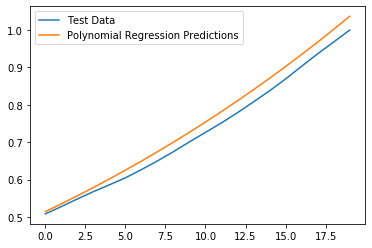

In [241]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

#### ARIMA

In [242]:
stepwise_fit = auto_arima(world_cases, start_p = 0, max_p = 8, max_q = 5, m = 12, start_P = 0, 
                          seasonal=True,d = None, D = 1, trace = True, error_action = 'ignore', 
                          supress_warnings=True,stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,2,2)x(0,1,1,12) [intercept=True]; AIC=3126.057, BIC=3141.009, Time=1.604 seconds
Fit ARIMA(0,2,0)x(0,1,0,12) [intercept=True]; AIC=3209.648, BIC=3215.629, Time=0.064 seconds
Fit ARIMA(1,2,0)x(1,1,0,12) [intercept=True]; AIC=3185.634, BIC=3197.596, Time=0.188 seconds
Fit ARIMA(0,2,1)x(0,1,1,12) [intercept=True]; AIC=3137.694, BIC=3149.656, Time=1.065 seconds
Near non-invertible roots for order (0, 2, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,2,0)x(0,1,0,12) [intercept=False]; AIC=3208.311, BIC=3211.301, Time=0.011 seconds
Fit ARIMA(0,2,2)x(0,1,0,12) [intercept=True]; AIC=3180.301, BIC=3192.263, Time=0.067 seconds
Fit ARIMA(0,2,2)x(1,1,1,12) [intercept=True]; AIC=3135.744, BIC=3153.687, Time=0.340 seconds
Fit ARIMA(0,2,2)x(0,1,2,12) [intercept=True]; AIC=3126.177, BIC=3144.120, Time=2.604 seconds
Fit ARIMA(0,2,2)x(1,1,0,12) [intercept=True]; AIC=315

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  161
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood               -1558.028
Date:                            Sat, 01 Aug 2020   AIC                           3126.057
Time:                                    20:29:55   BIC                           3141.009
Sample:                                         0   HQIC                          3132.132
                                            - 161                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     28.5284     40.095      0.712      0.477     -50.057     107.114
ar.L1          0.5007      0.216      2.315      0.021       0.077       0.925
ma.L1         -0.7315      0.200     -3.665      0.000      -1.123      -0.340
ma.S.L12      -0.9643      0.085    -11.315      0.000      -1.131      -0.797
sigma2      8.364e+07   2.43e-05   3.45e+12      0.000    8.36e+07    8.36e+07
===================================================================================
Ljung-Box (Q):                      233.96   Jarque-Bera (JB):                54.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              15.20   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+29. Standard errors may be unstable.
"""

In [255]:
model = SARIMAX(y_train, order=(1,2,1), seasonal_order=(0,1,1,12))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  141
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                 725.978
Date:                            Sat, 01 Aug 2020   AIC                          -1443.956
Time:                                    20:30:28   BIC                          -1432.579
Sample:                                         0   HQIC                         -1439.334
                                            - 141                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1378      0.102     -1.345      0.179      -0.339       0.063
ma.L1         -0.6817      0.052    -13.152      0.000      -0.783      -0.580
ma.S.L12      -0.5519      0.094     -5.899      0.000      -0.735      -0.369
sigma2      6.056e-07   4.71e-08     12.861      0.000    5.13e-07    6.98e-07
===================================================================================
Ljung-Box (Q):                       70.38   Jarque-Bera (JB):               158.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           20089.78   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [256]:
start = len(y_train)
end = len(y_train) + len(y_test) - 1

y_pred = result.predict(start, end, typ = 'levels')
y_pred = np.array(y_pred).reshape(-1,1)
print('MAE: ', mean_absolute_error(y_pred, y_test))
print('RMSE: ', mean_squared_error(y_pred, y_test, squared=False))

MAE:  0.026224761267499324
RMSE:  0.03778802058049813


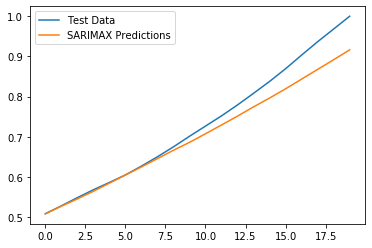

In [257]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test Data', 'SARIMAX Predictions'])

#### SVM

In [246]:
## Used for Hyperparamter search for SVM

# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5, 6]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1, verbose=3)
# svm_search.fit(X_train, y_train)

In [247]:
# svm_search.best_params_

In [248]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=0.01,degree=6, C=0.1)
svm_confirmed.fit(X_train, y_train)
print(svm_confirmed.score)

<bound method RegressorMixin.score of SVR(C=0.1, cache_size=200, coef0=0.0, degree=6, epsilon=0.01, gamma=0.01,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)>


In [249]:
svm_confirmed.score(X_train, y_train)

0.9971731466598326

MAE: 0.03892347509598223
RMSE: 0.04565006368967566


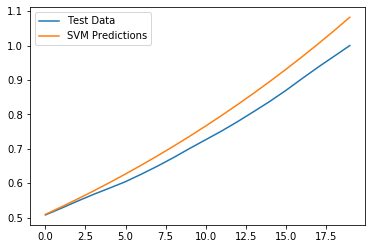

In [250]:
svm_test_pred = svm_confirmed.predict(X_test)
plt.plot(y_test)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
# print('Accuracy: ', accuracy_score(svm_test_pred, y_test))
print('MAE:', mean_absolute_error(svm_test_pred, y_test))
print('RMSE:',mean_squared_error(svm_test_pred, y_test, squared=False))

In [251]:
# Incorrect results

# Visible layer
inputLayer = Input(shape=(1,))
# First hidden layer
dense1 = Dense(80, name = "dense1")(inputLayer)
LRelu1 = LeakyReLU(name = "LRelu1")(dense1)
# Second hidden layer
dense2 = Dense(80, name = "dense2")(LRelu1)
LRelu2 = LeakyReLU(name = "LRelu2")(dense2)
# Third hidden layer
dense3 = Dense(80, name = "dense3")(LRelu2)
LRelu3 = LeakyReLU(name = "LRelu3")(dense3)
# Output layer
dense4 = Dense(1, name = 'dense4')(LRelu3)
LRelu4 = LeakyReLU(name = 'Output')(dense4)

regressor_model = models.Model(inputs = inputLayer, outputs = LRelu4)
regressor_model.compile(optimizer=Adam(lr=0.0001),
                       loss = 'mean_squared_error',
                       metrics = ['accuracy'])

regressor_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 80)                160       
_________________________________________________________________
LRelu1 (LeakyReLU)           (None, 80)                0         
_________________________________________________________________
dense2 (Dense)               (None, 80)                6480      
_________________________________________________________________
LRelu2 (LeakyReLU)           (None, 80)                0         
_________________________________________________________________
dense3 (Dense)               (None, 80)                6480      
_________________________________________________________________
LRelu3 (LeakyReLU)           (None, 80)                0   

In [252]:
y_pred = regressor_model.predict(X_test)

In [253]:
mean_squared_error(y_pred, y_test, squared=False)

10.932927455113408

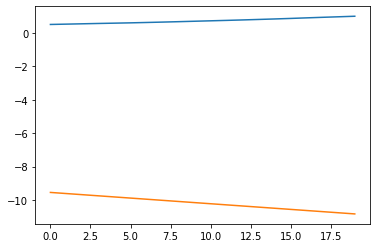

In [254]:
plt.plot(y_test)
plt.plot(y_pred)